# Problem set 2: Machine Learning 2024.
## Alumnos: Ara Francisco, Corradi Valentin, Di Placido Pedro.

In [517]:
import numpy as np
import pandas as pd

## General Instructions

El principal objetivo es construir un modelo que prediga la pobreza de los hogares. Un hogar es clasificado según la siguiente función indicadora:

$$
poor = I(Inc < Pl)
$$

Donde I indica si los ingresos de la familia están por debajo de cierto umbral.

Entonces, podemos seguir 2 caminos para hacer esta clasificación:

1 - Tomarlo como un problema de clasificación, donde se prediga 0 si no es pobre y 1 si lo es

2 - Predecir el ingreso, y luego fijarse si esta por debajo o por encima del umbral de pobreza.




## Introduction



In [518]:
import zipfile

zip_path = "mlunlp-2024-ps-2.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Listar todos los archivos dentro del ZIP
    print(zip_ref.namelist())

['mlunlp-2024-ps-2/', '__MACOSX/._mlunlp-2024-ps-2', 'mlunlp-2024-ps-2/train_hogares.csv', '__MACOSX/mlunlp-2024-ps-2/._train_hogares.csv', 'mlunlp-2024-ps-2/ddi-documentation-spanish-608.pdf', '__MACOSX/mlunlp-2024-ps-2/._ddi-documentation-spanish-608.pdf', 'mlunlp-2024-ps-2/test_personas.csv', '__MACOSX/mlunlp-2024-ps-2/._test_personas.csv', 'mlunlp-2024-ps-2/train_personas.csv', '__MACOSX/mlunlp-2024-ps-2/._train_personas.csv', 'mlunlp-2024-ps-2/test_hogares.csv', '__MACOSX/mlunlp-2024-ps-2/._test_hogares.csv', 'mlunlp-2024-ps-2/sample_submission.csv', '__MACOSX/mlunlp-2024-ps-2/._sample_submission.csv']


In [519]:
# import zipfile
import pandas as pd

# Ruta al archivo ZIP
zip_path = "mlunlp-2024-ps-2.zip"

# Leer archivos directamente desde el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Cargar los datos usando las rutas correctas
    with zip_ref.open('mlunlp-2024-ps-2/train_hogares.csv') as train_hogares_file:
        train_hogares = pd.read_csv(train_hogares_file)
    with zip_ref.open('mlunlp-2024-ps-2/train_personas.csv') as train_personas_file:
        train_personas = pd.read_csv(train_personas_file)
    with zip_ref.open('mlunlp-2024-ps-2/test_hogares.csv') as test_hogares_file:
        test_hogares = pd.read_csv(test_hogares_file)
    with zip_ref.open('mlunlp-2024-ps-2/test_personas.csv') as test_personas_file:
        test_personas = pd.read_csv(test_personas_file)
    with zip_ref.open('mlunlp-2024-ps-2/sample_submission.csv') as sample_submission_file:
        sample_submission = pd.read_csv(sample_submission_file)

# Inspeccionar los datos
print("Datos de train_hogares:")
print(train_hogares.head())
print("Datos de train_personas:")
print(train_personas.head())


Datos de train_hogares:
                         id  Clase   Dominio  P5000  P5010  P5090  P5100  \
0  8d0193e328305a042001a35f      1  MEDELLIN      4      2      1    NaN   
1  cf7491d7f2cc9c216bd009e7      1  MEDELLIN      5      4      3    NaN   
2  d90a57f64d2a84dbacbed2a5      1  MEDELLIN      4      2      1    NaN   
3  db34e387a94a783188ab3a33      1  MEDELLIN      3      1      1    NaN   
4  97bbef785824746ecab09c6f      1  MEDELLIN      4      3      3    NaN   

      P5130     P5140  Nper  ...       Ingpcug             Li            Lp  \
0  400000.0       NaN     5  ...  5.816661e+05  122809.534158  289878.24715   
1       NaN  250000.0     4  ...  1.612500e+05  122809.534158  289878.24715   
2  700000.0       NaN     3  ...  2.000000e+06  122809.534158  289878.24715   
3  450000.0       NaN     1  ...  2.450000e+06  122809.534158  289878.24715   
4       NaN  500000.0     5  ...  2.520000e+05  122809.534158  289878.24715   

   Pobre  Indigente  Npobres  Nindigentes   

In [520]:
import pandas as pd

# Identificar los 'id' faltantes en test_personas que están en test_hogares
ids_faltantes = set(test_hogares['id']) - set(test_personas['id'])
print(f"IDs faltantes: {ids_faltantes}")

# Crear un DataFrame con los 'id' faltantes
faltantes_df = pd.DataFrame(ids_faltantes, columns=['id'])

# Agregar las columnas de test_personas con valores predeterminados
for col in test_personas.columns:
    if col != 'id':
        faltantes_df[col] = 0  # Puedes ajustar el valor predeterminado según sea necesario

# Concatenar el DataFrame original con el DataFrame de 'id' faltantes
test_personas_completo = pd.concat([test_personas, faltantes_df], ignore_index=True)

# Verificar el número de filas y IDs faltantes
print(f"Número de filas en test_personas_completo después de agregar: {len(test_personas_completo)}")
ids_faltantes_completo = set(test_hogares['id']) - set(test_personas_completo['id'])
print(f"IDs faltantes en test_personas_completo: {ids_faltantes_completo}")

# Mostrar las primeras filas para verificar
display(test_personas_completo.head())

IDs faltantes: set()
Número de filas en test_personas_completo después de agregar: 219644
IDs faltantes en test_personas_completo: set()


,id,Orden,Clase,Dominio,P6020,P6040,P6050,P6090,P6100,P6210,...,P7510s5,P7510s6,P7510s7,Pet,Oc,Des,Ina,Fex_c,Depto,Fex_dpto
0,3279230a4917cdf883df34cd,1,1,MEDELLIN,1,33,1,1.0,1.0,6.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,125.720226,5,126.041802
1,3279230a4917cdf883df34cd,3,1,MEDELLIN,2,7,3,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.720226,5,126.041802
2,3279230a4917cdf883df34cd,2,1,MEDELLIN,2,37,2,1.0,1.0,6.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,125.720226,5,126.041802
3,3279230a4917cdf883df34cd,4,1,MEDELLIN,1,5,3,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.720226,5,126.041802
4,01bd1f72445acc719d19bd25,1,1,MEDELLIN,1,27,1,1.0,1.0,5.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,73.359246,5,64.143748


In [599]:
import pandas as pd

# Identificar los 'id' faltantes en test_personas que están en test_hogares
ids_hogares = set(test_hogares['id'])
ids_personas = set(test_personas['id'])
ids_faltantes = list(ids_hogares - ids_personas)
print(f"IDs faltantes: {ids_faltantes}")

# Crear un DataFrame con los 'id' faltantes
faltantes_df = pd.DataFrame(ids_faltantes, columns=['id'])

# Agregar una columna con ceros
faltantes_df['valor'] = 0

# Especificar la ruta de exportación
ruta_exportacion = '/Users/pedrodp/Library/CloudStorage/OneDrive-Personal/Documentos/MAECO UNLP/Machine Learning/ML_UNLP_Lectures/PS2/ML-TP2/predicciones/ids_faltantes.csv'

# Exportar el DataFrame a un archivo CSV en la ruta especificada
faltantes_df.to_csv(ruta_exportacion, index=False)

print(f"IDs faltantes exportados a '{ruta_exportacion}'")

IDs faltantes: ['772e3021a532b9b7e7f9b8eb', 'd71cb1ca01d7ec1168faa3b8', '171960ac5bd7f6e2253302fc', 'ee876b8508931406b86f3e79', '42ddfbb958f39f3a5ae2931f', '357d3f75827e2d01d823c4fb', 'bcc8df997727054c935b2ebe', '0cae522acf74d86342e50b01', '48e9e5fb7f2a97243a1da352', '69ef57ccce292da64aae5253', '0dd4971cf796f83fb1d135a0', '9e0d3cb0290e67e7e274c701', 'b140730a8092de3ce34e548a', 'eb8c1986080b72afc96a12e1', 'd7930517384faa26c6122adf']
IDs faltantes exportados a '/Users/pedrodp/Library/CloudStorage/OneDrive-Personal/Documentos/MAECO UNLP/Machine Learning/ML_UNLP_Lectures/PS2/ML-TP2/predicciones/ids_faltantes.csv'


In [516]:
# Crear una lista de los IDs faltantes
ids_faltantes_list = list(ids_faltantes)

# Crear un DataFrame con los IDs faltantes
ids_faltantes_df = pd.DataFrame(ids_faltantes_list, columns=['id'])

# Agregar una columna con valor 0
ids_faltantes_df['valor'] = 0

# Mostrar las primeras filas para verificar
print(ids_faltantes_df.head(15))

# Exportar el DataFrame a un archivo CSV en la carpeta 'predicciones'
ids_faltantes_df.to_csv('/Users/pedrodp/Library/CloudStorage/OneDrive-Personal/Documentos/MAECO UNLP/Machine Learning/ML_UNLP_Lectures/PS2/ML-TP2/predicciones/ids_faltantes.csv', index=False)

print("IDs faltantes exportados a 'predicciones/ids_faltantes.csv'")


IDs faltantes exportados a 'ids_faltantes.csv'
                         id  valor
0  772e3021a532b9b7e7f9b8eb      0
1  d71cb1ca01d7ec1168faa3b8      0
2  171960ac5bd7f6e2253302fc      0
3  ee876b8508931406b86f3e79      0
4  42ddfbb958f39f3a5ae2931f      0


In [521]:
unique_ids_count = test_personas['id'].nunique()
print(f"Cantidad de IDs únicos en test_personas: {unique_ids_count}")

Cantidad de IDs únicos en test_personas: 66168


In [522]:
# Matcheamos lo individual con el hogar. previamente le agregamos los sufijos _p o _h para saber su base original.

# # Personas
# train_personas = train_personas.rename(columns=lambda col: f"{col}_p" if col != "id" else col)
# train_hogares = train_hogares.rename(columns=lambda col: f"{col}_h" if col != "id" else col)
# train_all = train_personas.merge(train_hogares, on="id", how="inner")

# #Hogares
# test_personas = test_personas.rename(columns=lambda col: f"{col}_p" if col != "id" else col)
# test_hogares = test_hogares.rename(columns=lambda col: f"{col}_h" if col != "id" else col)
# test_all = test_personas.merge(test_hogares, on="id", how="inner")

# print(f'Dimensión train_all: {train_all.shape}, Dimensión test_all: {test_all.shape}')

In [523]:
print(train_hogares.shape)
print(train_personas.shape)
print(test_hogares.shape)
print(test_personas.shape)

(164960, 23)
(543109, 135)
(66168, 16)
(219644, 63)


Vemos que la dimensión de los df difiere. La muestra de testeo no tiene las variables relacionadas al ingreso o el indicador de pobreza/indigencia. Esto no debiera afectarnos ya que es la variable que buscamos predecir. Recordemos que un metodo a utilizar es categórico, donde en base a los predictores se clasifica directamente en pobre o no pobre, y el otro es "indirecto", donde primero se predice el ingreso y en base a eso se hace luego la clasificación.

In [524]:
#print(train_hogares.columns)
#print(test_hogares.columns)

print(f'Las variables que difieren en los hogares son: \n{set(train_hogares.columns) - set(test_hogares.columns)}')

#print(train_personas.columns)
#print(test_personas.columns)

print(f'Las variables que difieren en las personas son: \n {set(train_personas.columns) - set(test_personas.columns)}')

Las variables que difieren en los hogares son: 
{'Ingtotug', 'Ingtotugarr', 'Nindigentes', 'Npobres', 'Pobre', 'Indigente', 'Ingpcug'}
Las variables que difieren en las personas son: 
 {'Iees', 'Cclasnr4', 'P6585s2a1', 'P6610s1', 'P6585s1a1', 'Iof3hes', 'P6585s1a2', 'Isa', 'P6630s2a1', 'P550', 'P7510s5a1', 'Cclasnr5', 'Impa', 'Ingtotes', 'Cclasnr6', 'Iof6es', 'P7500s2a1', 'P7500s3a1', 'Iof1es', 'Iof1', 'P6585s4a2', 'Imdies', 'Cclasnr11', 'P6585s3a1', 'P7422s1', 'Cclasnr2', 'Ie', 'P7510s2a1', 'P7500s1', 'P6510s1', 'Ingtot', 'P6545s1', 'P7510s1a1', 'Cclasnr3', 'P6750', 'P7140s1', 'Iof6', 'P6580s1', 'P6620s1', 'P7140s2', 'Iof2', 'Impaes', 'P6585s2a2', 'P6585s3a2', 'Imdi', 'P6545s2', 'P7510s3a1', 'P7500s1a1', 'P6500', 'P6760', 'P6590s1', 'Isaes', 'Iof3i', 'P6510s2', 'Cclasnr8', 'P6630s1a1', 'P6630s4a1', 'P7070', 'Cclasnr7', 'Ingtotob', 'P6630s6a1', 'P6585s4a1', 'P6630s3a1', 'Iof3h', 'Estrato1', 'P7510s6a1', 'P7472s1', 'P6600s1', 'P6580s2', 'P7510s7a1', 'Iof3ies', 'Iof2es'}


In [525]:
# print(train_hogares.columns)
print(F'test per: {train_hogares.columns}')

test per: Index(['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130',
       'P5140', 'Nper', 'Npersug', 'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li',
       'Lp', 'Pobre', 'Indigente', 'Npobres', 'Nindigentes', 'Fex_c', 'Depto',
       'Fex_dpto'],
      dtype='object')


# Chart descriptivo

In [526]:
print("Variables en train_hogares:")
print(train_hogares.columns)


Variables en train_hogares:
Index(['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130',
       'P5140', 'Nper', 'Npersug', 'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li',
       'Lp', 'Pobre', 'Indigente', 'Npobres', 'Nindigentes', 'Fex_c', 'Depto',
       'Fex_dpto'],
      dtype='object')


## Variables Seleccionadas: Hogares

- **`id`**: Identificador único del hogar.
- **`Pobre`**: Indicador de pobreza del hogar.
- **`Ingpcug`**: Ingreso per cápita del hogar.
- **`P5010`**: Número de cuartos donde duermen las personas.
- **`P5090`**: Régimen de tenencia de la vivienda (propia, alquilada, etc.).
- **`P5130`**: Monto estimado de arriendo.
- **`Nper`**: Número de personas en el hogar.
- **`Clase`**: Clasificación del hogar (cabecera o resto del área).
- **`Fex_c`**: Factor de expansión anualizado.


In [527]:
columnas_hogares = ['id', 'P5000', 'P5010', 'P5090', 'P5130', 'Nper', 'Ingpcug', 'Clase', 'Fex_c', 'Pobre']
train_hogares = train_hogares[columnas_hogares]

## Variables Seleccionadas: Personas

- **`id`**: Identificador único del individuo.
- **`P6020`**: Sexo (1 hombre, 2 mujer).
- **`P6040`**: Edad de la persona.
- **`P6050`**: Parentezco con el jefe de hogar.
- **`P6090`**: Afilación a la seguridad social.
- **`P6210`**: Nivel educativo alcanzado.
- **`P6430`**: Tipo de empleo
- **`P6585s1`**: subsidio por alimentacion.
- **`P6585s3a1`**: Subsidio familiar.(sacado)
- **`P7040`**: Dummy de ocupación secundaria (1 tiene ,2 no tiene)
- **`P7045`**: Horas trabajadas en ocupacion secundaria.
- **`P6800`**: Horas trabajadas por semana. (sacado)
- **`P6870`**: Numero de empleados de la empresa. (sacado)
- **`Ingtot`**: Ingreso total del individuo.
- **`Oc`**: Dummy de ocupación.

In [528]:
# Selección de columnas relevantes incluyendo 'Pobre' para el merge
columnas_personas = ['id','Orden', 'P6020', 'P6040','P6050','P6090', 'P6210','P6430','P6585s1','P6585s3a1', 'P7040','P7045','Oc']
train_personas = train_personas[columnas_personas]

Grafico sccater con distribuciones combinados

grafico de mosaicos para pobre/nopobre

El gráfico de mosaico muestra la relación entre la pobreza (`Pobre`) y el número de habitaciones de la vivienda (`P5090`). Los hogares pobres (`Pobre = 1`) están representados en rojo oscuro y se concentran mayoritariamente en las categorías con menos habitaciones, lo que sugiere condiciones de hacinamiento. Por otro lado, los hogares no pobres (`Pobre = 0`), representados en verde, se distribuyen en su mayoría en categorías con un mayor número de habitaciones. El área de cada sección es proporcional a la cantidad de hogares en cada combinación de categorías, y visualmente se observa que la pobreza está asociada con viviendas de menor tamaño, mientras que los hogares no pobres tienden a tener más habitaciones disponibles.

kFOLD CON 5 REPETICIONES

##### imputamos valores faltantes

In [529]:
# Crear una columna dummy que indique si el hogar recibió subsidio
train_personas['recibio_subsidio'] = ((train_personas['P6585s1'] > 0) | (train_personas['P6585s3a1'] > 0)).astype(int)

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6585s1', 'P6585s3a1', 'recibio_subsidio']].head())

                         id  P6585s1  P6585s3a1  recibio_subsidio
0  8d0193e328305a042001a35f      2.0    75000.0                 1
1  8d0193e328305a042001a35f      NaN        NaN                 0
2  8d0193e328305a042001a35f      2.0    81000.0                 1
3  8d0193e328305a042001a35f      NaN        NaN                 0
4  8d0193e328305a042001a35f      NaN        NaN                 0


In [530]:
# Ordenar la base de hogares por 'id'
train_hogares = train_hogares.sort_values(by='id')

# Ordenar la base de personas por 'id' y 'orden'
train_personas = train_personas.sort_values(by=['id', 'Orden'])

In [531]:
# Calculate the proportion of men in each household
train_personas['prop_sexo'] = train_personas.groupby('id')['P6020'].transform(lambda x: (x == 1).sum() / len(x))

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P6020', 'prop_sexo']].head()) #No genera ningún NaN

                              id  P6020  prop_sexo
115620  00004a3f76ed8c33d84a5c70      2        0.4
115621  00004a3f76ed8c33d84a5c70      1        0.4
115622  00004a3f76ed8c33d84a5c70      2        0.4
115618  00004a3f76ed8c33d84a5c70      2        0.4
115619  00004a3f76ed8c33d84a5c70      1        0.4


VER QUE HACEMOS SI GENERA ALGUNOS NAN

In [532]:
# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = train_personas[train_personas['P6050'] == 1]

# Crear un diccionario con la relación 'id' del hogar y la posición ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posición ocupacional del jefe a la nueva variable 'ocup_jefe' en la train_personas
train_personas['ocup_jefe'] = train_personas['id'].map(jefe_ocupacion)

# Mostrar las primeras filas para verificar
train_personas[['id', 'ocup_jefe']]

,id,ocup_jefe
115620,00004a3f76ed8c33d84a5c70,NaN
115621,00004a3f76ed8c33d84a5c70,NaN
115622,00004a3f76ed8c33d84a5c70,NaN
115618,00004a3f76ed8c33d84a5c70,NaN
115619,00004a3f76ed8c33d84a5c70,NaN
...,...,...
247107,ffff32451ed4afe313eb8e8d,4.0
247105,ffff32451ed4afe313eb8e8d,4.0
212028,ffffa463e09fef53f2798f82,NaN
212029,ffffa463e09fef53f2798f82,NaN


In [533]:
# Crear una columna que indique si la persona está ocupada (1 si está ocupada, 0 si no)
train_personas['ocupada'] = (train_personas['Oc'] == 1).astype(int)

# Calcular la proporción de personas ocupadas por hogar
train_personas['prop_ocup'] = train_personas.groupby('id')['ocupada'].transform('mean')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'ocupada', 'prop_ocup']].head(5))

                              id  ocupada  prop_ocup
115620  00004a3f76ed8c33d84a5c70        0        0.2
115621  00004a3f76ed8c33d84a5c70        1        0.2
115622  00004a3f76ed8c33d84a5c70        0        0.2
115618  00004a3f76ed8c33d84a5c70        0        0.2
115619  00004a3f76ed8c33d84a5c70        0        0.2


In [534]:
# Crear una columna que indique si la persona es mayor a 10 años (1 si es mayor a 10 años, 0 si no)
train_personas['mayor_10'] = (train_personas['P6040'] > 10).astype(int)

# Calcular la proporción de personas mayores a 10 años por hogar
train_personas['prop_mayores10'] = train_personas.groupby('id')['mayor_10'].transform('mean')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6040', 'mayor_10', 'prop_mayores10']].head())

                              id  P6040  mayor_10  prop_mayores10
115620  00004a3f76ed8c33d84a5c70     31         1             0.6
115621  00004a3f76ed8c33d84a5c70     36         1             0.6
115622  00004a3f76ed8c33d84a5c70     15         1             0.6
115618  00004a3f76ed8c33d84a5c70      6         0             0.6
115619  00004a3f76ed8c33d84a5c70      3         0             0.6


revisar nan de la variable P6090

In [535]:
# Filter out rows where P6090 is 9
train_personas = train_personas[train_personas['P6090'] != 9]

# Create a column that indicates if the person is affiliated with social security (1 if affiliated, 0 if not)
train_personas['afiliado'] = (train_personas['P6090'] == 1).astype(int)

# Calculate the proportion of affiliated individuals in each household
train_personas['prop_afiliado'] = train_personas.groupby('id')['afiliado'].transform('mean')

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P6090', 'afiliado', 'prop_afiliado']].head())

                              id  P6090  afiliado  prop_afiliado
115620  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115621  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115622  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115618  00004a3f76ed8c33d84a5c70    NaN         0            0.6
115619  00004a3f76ed8c33d84a5c70    NaN         0            0.6


In [536]:
# Create a column that indicates if the person has a secondary occupation (1 if they have, 0 if not)
train_personas['ocupacion_secundaria'] = (train_personas['P7040'] == 1).astype(int)

# Calculate the proportion of people with a secondary occupation in each household
train_personas['prop_ocup2'] = train_personas.groupby('id')['ocupacion_secundaria'].transform('mean')

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P7040', 'ocupacion_secundaria', 'prop_ocup2']].head())

                              id  P7040  ocupacion_secundaria  prop_ocup2
115620  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115621  00004a3f76ed8c33d84a5c70    2.0                     0         0.0
115622  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115618  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115619  00004a3f76ed8c33d84a5c70    NaN                     0         0.0


In [537]:


# Agrupar por 'id' y quedarnos con la primera fila de cada grupo
variables = ['id', 'prop_sexo', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2','prop_afiliado']
train_personas_agg = train_personas[variables].drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Mostrar las primeras filas para verificar
display(train_personas_agg.head())

,id,prop_sexo,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00004a3f76ed8c33d84a5c70,0.400000,0,0.200000,1,0.600000,0,0,0.000000,0.600000
1,000088edf78cfaaf1791beba,0.333333,0,0.333333,1,0.666667,0,0,0.333333,0.666667
2,00009b13480f6770b6a4d1e9,0.666667,1,0.666667,1,1.000000,0,0,0.000000,1.000000
3,0000b1899fb63a7bf0b73ccf,0.500000,1,0.500000,1,1.000000,0,0,0.000000,1.000000
4,0000f3ec65ccacadfcc59f32,0.333333,0,0.666667,1,1.000000,0,0,0.000000,1.000000


In [538]:
print(f"Number of rows in train_personas_agg: {train_personas_agg.shape[0]}")
print(f"Number of rows in train_hogares: {train_hogares.shape[0]}")

Number of rows in train_personas_agg: 164933
Number of rows in train_hogares: 164960


In [539]:
# Hacer un merge de train_hogares con train_personas_agg usando la columna 'id' con un inner join
train_hogares2 = train_hogares.merge(train_personas_agg, on='id', how='inner')

# Mostrar las primeras filas para verificar
train_hogares2.head()

,id,P5000,P5010,P5090,P5130,Nper,Ingpcug,Clase,Fex_c,Pobre,prop_sexo,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00004a3f76ed8c33d84a5c70,3,2,1,250000.0,5,265285.883333,1,535.091737,1,0.400000,0,0.200000,1,0.600000,0,0,0.000000,0.600000
1,000088edf78cfaaf1791beba,3,2,3,NaN,3,344166.666667,1,48.637019,0,0.333333,0,0.333333,1,0.666667,0,0,0.333333,0.666667
2,00009b13480f6770b6a4d1e9,4,3,1,700000.0,3,833333.333333,1,18.831041,0,0.666667,1,0.666667,1,1.000000,0,0,0.000000,1.000000
3,0000b1899fb63a7bf0b73ccf,5,2,1,70000.0,2,355000.000000,2,48.193596,0,0.500000,1,0.500000,1,1.000000,0,0,0.000000,1.000000
4,0000f3ec65ccacadfcc59f32,4,2,1,350000.0,3,720830.666667,1,11.184193,0,0.333333,0,0.666667,1,1.000000,0,0,0.000000,1.000000


#### Estadisticas descriptivas

In [540]:
import pandas as pd

# Cargar el DataFrame (asegúrate de que train_hogares2 esté cargado en tu entorno)
# train_hogares2 = pd.read_csv('ruta_a_tu_archivo.csv')

# Generar estadísticas descriptivas
descriptive_stats = train_hogares2.describe(percentiles=[.25, .5, .75])

# Seleccionar solo las filas de interés
descriptive_stats = descriptive_stats.loc[['min', '25%', '50%', '75%', 'max', 'mean']]

# Mostrar las estadísticas descriptivas
descriptive_stats

,P5000,P5010,P5090,P5130,Nper,Ingpcug,Clase,Fex_c,Pobre,prop_sexo,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
min,1.000000,1.000000,1.000000,9.800000e+01,1.000000,0.000000e+00,1.000000,1.277095,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,2.000000e+05,2.000000,3.000000e+05,1.000000,12.367640,0.000000,0.333333,0.000000,0.250000,1.000000,0.750000,0.00000,0.000000,0.000000,0.666667
50%,3.000000,2.000000,3.000000,3.500000e+05,3.000000,5.435623e+05,1.000000,26.815928,0.000000,0.500000,1.000000,0.500000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000
75%,4.000000,3.000000,3.000000,5.000000e+05,4.000000,9.874800e+05,1.000000,87.081887,0.000000,0.666667,1.000000,0.666667,1.000000,1.000000,1.00000,0.000000,0.000000,1.000000
max,98.000000,15.000000,6.000000,6.000000e+08,28.000000,8.883333e+07,2.000000,918.608881,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
mean,3.390546,1.989493,2.456404,4.998881e+05,3.292695,8.706838e+05,1.093796,66.609544,0.200184,0.474199,0.710197,0.498147,0.999976,0.874900,0.31437,0.041259,0.025904,0.807329


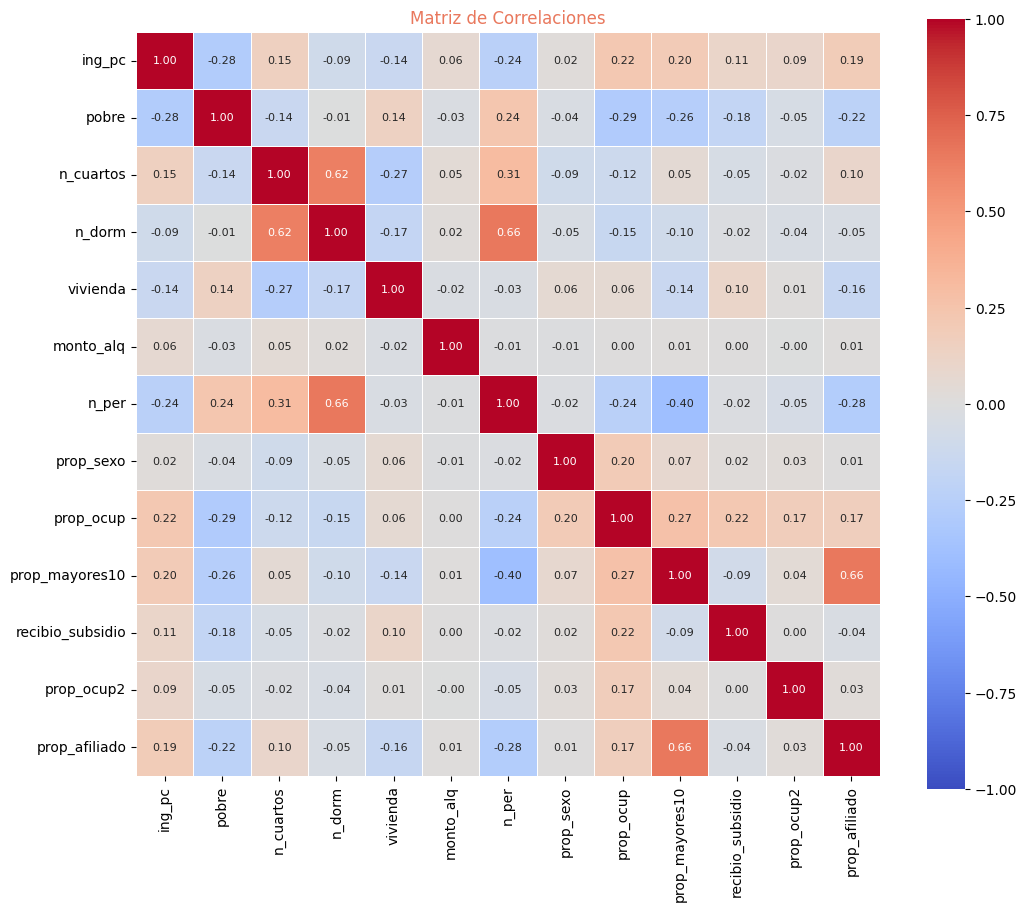

In [541]:
# Renombrar las columnas
train_hogares2.rename(columns={
    'P5000': 'n_cuartos',
    'P5010': 'n_dorm',
    'P5090': 'vivienda',
    'P5130': 'monto_alq',
    'Nper': 'n_per',
    'Pobre': 'pobre',
    'Ingpcug': 'ing_pc',
    'Fex_c': 'fex_c'
}, inplace=True)

# Seleccionar las columnas de interés para la matriz de correlaciones
columnas_interes = ['ing_pc', 'pobre', 'n_cuartos','n_dorm','vivienda', 'monto_alq','n_per', 'prop_sexo', 'prop_ocup', 'prop_mayores10', 'recibio_subsidio', 'prop_ocup2', 'prop_afiliado']

# Calcular la matriz de correlaciones
corr_matrix = train_hogares2[columnas_interes].corr()

# Crear el mapa de calor con escala fija de -1 a 1
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 8}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gráfico
plt.title('Matriz de Correlaciones', color='#E9785D')
plt.show()

In [542]:
# Agrupar por tamaño del hogar y calcular la proporción de hogares pobres
#proporcion_pobreza_por_tamano = train_hogares2.groupby('n_per')['pobre'].mean()

# Mostrar los resultados


### Grafico de pobres por numero de personas
#print(proporcion_pobreza_por_tamano)
# Graficar la proporción de hogares pobres por tamaño del hogar
#proporcion_pobreza_por_tamano.plot(kind='bar', figsize=(10, 6), color='skyblue')
#plt.title('Proporción de Hogares Pobres por Tamaño del Hogar')
#plt.xlabel('Tamaño del Hogar (Número de Personas)')
#plt.ylabel('Proporción de Hogares Pobres')
#plt.xticks(rotation=0)
#plt.show()

#### union test

In [543]:
columnas_hogares = ['id', 'P5000', 'P5010', 'P5090', 'P5130', 'Nper', 'Clase', 'Fex_c']
test_hogares = test_hogares[columnas_hogares]
# Selección de columnas relevantes incluyendo 'Pobre' para el merge
columnas_personas = ['id','Orden', 'P6020', 'P6040','P6050','P6090', 'P6210','P6430','P6585s1', 'P7040','P7045','Oc']
test_personas = test_personas[columnas_personas]
# Crear una columna dummy que indique si el hogar recibió subsidio
test_personas['recibio_subsidio'] = ((test_personas['P6585s1'] > 0)).astype(int)

In [544]:


# Mostrar las primeras filas para verificar
print(test_personas[['id', 'P6585s1', 'recibio_subsidio']].head())
# Ordenar la base de hogares por 'id'
test_hogares = test_hogares.sort_values(by='id')

# Ordenar la base de personas por 'id' y 'orden'
test_personas = test_personas.sort_values(by=['id', 'Orden'])
# Calculate the proportion of men in each household
test_personas['prop_sexo'] = test_personas.groupby('id')['P6020'].transform(lambda x: (x == 1).sum() / len(x))

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P6020', 'prop_sexo']].head()) #No genera ningún NaN
# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = test_personas[test_personas['P6050'] == 1]

# Crear un diccionario con la relación 'id' del hogar y la posición ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posición ocupacional del jefe a la nueva variable 'ocup_jefe' en la test_personas
test_personas['ocup_jefe'] = test_personas['id'].map(jefe_ocupacion)

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'ocup_jefe']].head(5))
# Crear una columna que indique si la persona está ocupada (1 si está ocupada, 0 si no)
test_personas['ocupada'] = (test_personas['Oc'] == 1).astype(int)

# Calcular la proporción de personas ocupadas por hogar
test_personas['prop_ocup'] = test_personas.groupby('id')['ocupada'].transform('mean')

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'ocupada', 'prop_ocup']].head(5))
# Crear una columna que indique si la persona es mayor a 10 años (1 si es mayor a 10 años, 0 si no)
test_personas['mayor_10'] = (test_personas['P6040'] > 10).astype(int)

# Calcular la proporción de personas mayores a 10 años por hogar
test_personas['prop_mayores10'] = test_personas.groupby('id')['mayor_10'].transform('mean')

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'P6040', 'mayor_10', 'prop_mayores10']].head())
# Filter out rows where P6090 is 9
test_personas = test_personas[test_personas['P6090'] != 9]

# Create a column that indicates if the person is affiliated with social security (1 if affiliated, 0 if not)
test_personas['afiliado'] = (test_personas['P6090'] == 1).astype(int)

# Calculate the proportion of affiliated individuals in each household
test_personas['prop_afiliado'] = test_personas.groupby('id')['afiliado'].transform('mean')

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P6090', 'afiliado', 'prop_afiliado']].head())
# Create a column that indicates if the person has a secondary occupation (1 if they have, 0 if not)
test_personas['ocupacion_secundaria'] = (test_personas['P7040'] == 1).astype(int)

# Calculate the proportion of people with a secondary occupation in each household
test_personas['prop_ocup2'] = test_personas.groupby('id')['ocupacion_secundaria'].transform('mean')

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P7040', 'ocupacion_secundaria', 'prop_ocup2']].head())

                         id  P6585s1  recibio_subsidio
0  3279230a4917cdf883df34cd      2.0                 1
1  3279230a4917cdf883df34cd      NaN                 0
2  3279230a4917cdf883df34cd      2.0                 1
3  3279230a4917cdf883df34cd      NaN                 0
4  01bd1f72445acc719d19bd25      NaN                 0
                              id  P6020  prop_sexo
114499  00007322a7918c7799e7a514      2        0.0
101740  0004847804c0618d4633b196      1        0.5
101741  0004847804c0618d4633b196      2        0.5
40523   0004add76858a3b0cc39eb9b      1        0.8
40524   0004add76858a3b0cc39eb9b      2        0.8
                              id  ocup_jefe
114499  00007322a7918c7799e7a514        1.0
101740  0004847804c0618d4633b196        4.0
101741  0004847804c0618d4633b196        4.0
40523   0004add76858a3b0cc39eb9b        2.0
40524   0004add76858a3b0cc39eb9b        2.0
                              id  ocupada  prop_ocup
114499  00007322a7918c7799e7a514        1      

In [545]:
# Definir las variables a agrupar
variables = ['id', 'prop_sexo', 'ocup_jefe', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2', 'prop_afiliado']

# Agrupar por 'id' y aplicar una función de agregación adecuada para cada columna
test_personas_agg = test_personas.groupby('id').agg({
    'prop_sexo': 'mean',  # Promedio de la proporción de sexo
    'ocup_jefe': 'first',  # Mantener el primer valor de ocupación del jefe
    'ocupada': 'mean',  # Promedio de la proporción de ocupados
    'prop_ocup': 'mean',  # Promedio de la proporción de ocupación
    'mayor_10': 'mean',  # Promedio de la proporción de mayores de 10 años
    'prop_mayores10': 'mean',  # Promedio de la proporción de mayores de 10 años
    'recibio_subsidio': 'first',  # Mantener el primer valor de si recibió subsidio
    'ocupacion_secundaria': 'mean',  # Promedio de la proporción de ocupación secundaria
    'prop_ocup2': 'mean',  # Promedio de la proporción de ocupación secundaria
    'prop_afiliado': 'mean'  # Promedio de la proporción de afiliados
}).reset_index()

# Mostrar las primeras filas para verificar
display(test_personas_agg.head())

,id,prop_sexo,ocup_jefe,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00007322a7918c7799e7a514,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1,1.0,1.0,1.000000
1,0004847804c0618d4633b196,0.5,4.0,0.500000,0.500000,1.000000,1.000000,0,0.0,0.0,1.000000
2,0004add76858a3b0cc39eb9b,0.8,2.0,0.200000,0.200000,0.800000,0.800000,1,0.0,0.0,0.600000
3,000804ac64d779b35ee5edfa,0.5,4.0,0.333333,0.333333,0.833333,0.833333,0,0.0,0.0,0.833333
4,000b6a116b7f95b043a6e77b,0.0,1.0,0.500000,0.500000,0.500000,0.500000,1,0.0,0.0,1.000000


In [546]:
test_personas_agg.shape

(66153, 11)

In [547]:
# Agrupar por 'id' y quedarnos con la primera fila de cada grupo
variables = ['id', 'prop_sexo', 'ocup_jefe', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2','prop_afiliado']
test_personas_agg = test_personas[variables].drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Mostrar las primeras filas para verificar
display(test_personas_agg.head())

,id,prop_sexo,ocup_jefe,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00007322a7918c7799e7a514,0.0,1.0,1,1.000000,1,1.000000,1,1,1.0,1.000000
1,0004847804c0618d4633b196,0.5,4.0,1,0.500000,1,1.000000,0,0,0.0,1.000000
2,0004add76858a3b0cc39eb9b,0.8,2.0,1,0.200000,1,0.800000,1,0,0.0,0.600000
3,000804ac64d779b35ee5edfa,0.5,4.0,1,0.333333,1,0.833333,0,0,0.0,0.833333
4,000b6a116b7f95b043a6e77b,0.0,1.0,1,0.500000,1,0.500000,1,0,0.0,1.000000


In [548]:
test_personas_agg.shape

(66153, 11)

In [549]:
# Hacer un merge de train_hogares con train_personas_agg usando la columna 'id' con un inner join
test_hogares2 = test_hogares.merge(test_personas_agg, on='id', how='inner')

# Mostrar las primeras filas para verificar
test_hogares2.head()

,id,P5000,P5010,P5090,P5130,Nper,Clase,Fex_c,prop_sexo,ocup_jefe,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00007322a7918c7799e7a514,3,1,1,600000.0,1,1,18.600075,0.0,1.0,1,1.000000,1,1.000000,1,1,1.0,1.000000
1,0004847804c0618d4633b196,3,1,3,NaN,2,1,37.168351,0.5,4.0,1,0.500000,1,1.000000,0,0,0.0,1.000000
2,0004add76858a3b0cc39eb9b,4,3,3,NaN,5,1,9.395218,0.8,2.0,1,0.200000,1,0.800000,1,0,0.0,0.600000
3,000804ac64d779b35ee5edfa,1,1,4,150000.0,6,1,8.689642,0.5,4.0,1,0.333333,1,0.833333,0,0,0.0,0.833333
4,000b6a116b7f95b043a6e77b,4,2,1,200000.0,2,2,133.359515,0.0,1.0,1,0.500000,1,0.500000,1,0,0.0,1.000000


In [550]:
# Renombrar las columnas
test_hogares2.rename(columns={
    'P5000': 'n_cuartos',
    'P5010': 'n_dorm',
    'P5090': 'vivienda',
    'P5130': 'monto_alq',
    'Nper': 'n_per',
    'Pobre': 'pobre',
    'Ingpcug': 'ing_pc',
    'Fex_c': 'fex_c'
}, inplace=True)

### Preparo los datos

In [551]:
# Merge test_hogares2 with sample_submission on 'id'
test_hogares2 = test_hogares2.merge(sample_submission, on='id', how='inner')

# Display the first few rows to verify the merge
test_hogares2.head()

,id,n_cuartos,n_dorm,vivienda,monto_alq,n_per,Clase,fex_c,prop_sexo,ocup_jefe,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado,pobre
0,00007322a7918c7799e7a514,3,1,1,600000.0,1,1,18.600075,0.0,1.0,1,1.000000,1,1.000000,1,1,1.0,1.000000,0
1,0004847804c0618d4633b196,3,1,3,NaN,2,1,37.168351,0.5,4.0,1,0.500000,1,1.000000,0,0,0.0,1.000000,1
2,0004add76858a3b0cc39eb9b,4,3,3,NaN,5,1,9.395218,0.8,2.0,1,0.200000,1,0.800000,1,0,0.0,0.600000,1
3,000804ac64d779b35ee5edfa,1,1,4,150000.0,6,1,8.689642,0.5,4.0,1,0.333333,1,0.833333,0,0,0.0,0.833333,0
4,000b6a116b7f95b043a6e77b,4,2,1,200000.0,2,2,133.359515,0.0,1.0,1,0.500000,1,0.500000,1,0,0.0,1.000000,0


In [552]:
ids = test_hogares2['id']

y_train = train_hogares2['pobre']
y_test = test_hogares2['pobre']
X_train = train_hogares2.drop(columns=['id', 'pobre', 'fex_c', 'ing_pc'])
X_test = test_hogares2.drop(columns=['id', 'pobre', 'fex_c', 'ocup_jefe'])


In [553]:
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_recall_curve
import numpy as np

# Imputar valores faltantes en X_train y X_test
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Balancear las clases utilizando SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

# Crear y entrenar el modelo de ElasticNet con validación cruzada
elastic_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 1.0], cv=5, random_state=42)
elastic_model.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones
y_pred_elastic = elastic_model.predict(X_test_imputed)

# Calcular el MSE
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print(f"Error cuadrático medio (MSE) en prueba: {mse_elastic:.4f}")

# Calcular la curva de precisión-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_elastic)

# Calcular el F1-Score para cada umbral
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Encontrar el umbral con el mejor F1-Score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para F1-Score: {best_threshold:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando el mejor umbral
y_pred_binary_elastic = (y_pred_elastic >= best_threshold).astype(int)

# Calcular métricas con el mejor umbral
accuracy_elastic = accuracy_score(y_test, y_pred_binary_elastic)
f1_elastic = f1_score(y_test, y_pred_binary_elastic)

print(f"Accuracy: {accuracy_elastic:.4f}")
print(f"F1-Score: {f1_elastic:.4f}")

# Mostrar los coeficientes del modelo
coeficientes_elastic = pd.Series(elastic_model.coef_, index=X_train.columns)
print("Coeficientes del modelo de ElasticNet:")
print(coeficientes_elastic.sort_values())

Error cuadrático medio (MSE) en prueba: 0.2511
Mejor umbral para F1-Score: -0.7991
Accuracy: 0.4991
F1-Score: 0.6659
Coeficientes del modelo de ElasticNet:
monto_alq              -7.232180e-09
n_cuartos              -0.000000e+00
n_dorm                 -0.000000e+00
vivienda                0.000000e+00
n_per                   0.000000e+00
Clase                   0.000000e+00
prop_sexo              -0.000000e+00
ocupada                -0.000000e+00
prop_ocup              -0.000000e+00
mayor_10               -0.000000e+00
prop_mayores10         -0.000000e+00
recibio_subsidio       -0.000000e+00
ocupacion_secundaria   -0.000000e+00
prop_ocup2             -0.000000e+00
prop_afiliado          -0.000000e+00
dtype: float64


Accuracy (Bagged-RF): 0.4973
F1-Score (Bagged-RF): 0.3230


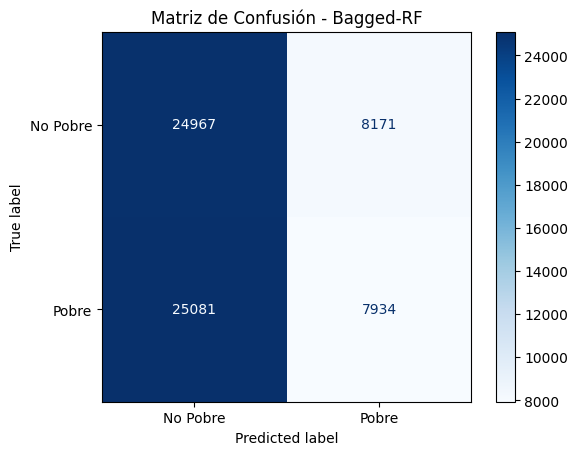

Características seleccionadas: ['n_cuartos', 'monto_alq', 'prop_sexo', 'prop_ocup', 'prop_mayores10', 'recibio_subsidio', 'prop_afiliado']


In [554]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Crear un imputador para llenar los valores faltantes
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Balancear las clases utilizando SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

# Crear y entrenar el modelo RandomForest para la selección de características
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Seleccionar las características más importantes
selector = SelectFromModel(rf_model, prefit=True)
X_train_selected = selector.transform(X_train_balanced)
X_test_selected = selector.transform(X_test_imputed)

# Crear y entrenar el modelo Bagging con un árbol de decisión como modelo base
base_model = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=100, random_state=42)
bagging_model.fit(X_train_selected, y_train_balanced)

# Realizar predicciones
y_pred_bagging_selected = bagging_model.predict(X_test_selected)

# Calcular métricas
accuracy_bagging_selected = accuracy_score(y_test, y_pred_bagging_selected)
f1_bagging_selected = f1_score(y_test, y_pred_bagging_selected)
print(f"Accuracy (Bagged-RF): {accuracy_bagging_selected:.4f}")
print(f"F1-Score (Bagged-RF): {f1_bagging_selected:.4f}")

# Matriz de confusión
cm_bagging_selected = confusion_matrix(y_test, y_pred_bagging_selected)
disp_bagging_selected = ConfusionMatrixDisplay(confusion_matrix=cm_bagging_selected, display_labels=["No Pobre", "Pobre"])
disp_bagging_selected.plot(cmap="Blues")
plt.title("Matriz de Confusión - Bagged-RF")
plt.show()

# Mostrar las características seleccionadas
selected_features = X_train.columns[selector.get_support()]
print("Características seleccionadas:", list(selected_features))

In [555]:
import joblib

# Save the RandomForestClassifier model to a file
model_filename = 'random_forest_classifier_model.pkl'
joblib.dump(rf_model, model_filename)

print(f"RandomForestClassifier model saved to {model_filename}")

RandomForestClassifier model saved to random_forest_classifier_model.pkl


In [556]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [557]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#### Imputar valores faltantes

In [558]:
# Imputar valores faltantes
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')
#X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
#X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Get the common columns between X_train and X_test
common_cols = X_train.columns.intersection(X_test.columns)

# Select only the common columns for both training and testing data
X_train_common = X_train[common_cols]
X_test_common = X_test[common_cols]

# Imputar valores faltantes using the common columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train_common), columns=common_cols)
X_test = pd.DataFrame(imputer.transform(X_test_common), columns=common_cols)


### Bagging random forest

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Accuracy (Bagging con selección de características): 0.4994
F1-Score (Bagging con selección de características): 0.2196


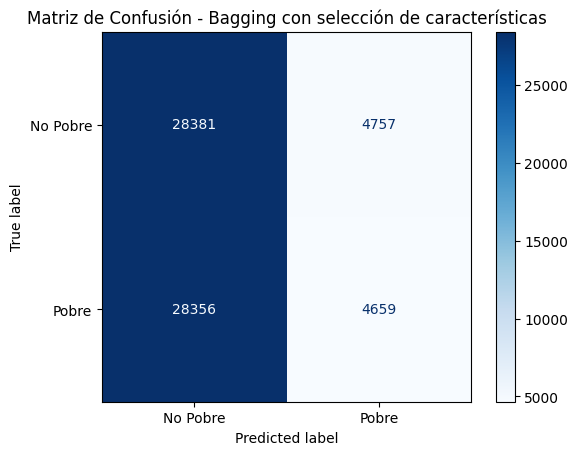

Características seleccionadas: ['n_cuartos', 'vivienda', 'monto_alq', 'prop_sexo', 'prop_ocup', 'prop_mayores10', 'prop_afiliado']


In [559]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Crear y entrenar el modelo RandomForest para la selección de características
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Seleccionar las características más importantes
selector = SelectFromModel(rf_model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Crear y entrenar el modelo Bagging con un árbol de decisión como modelo base
base_model = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=100, random_state=42)
bagging_model.fit(X_train_selected, y_train)

# Realizar predicciones
y_pred_bagging_selected = bagging_model.predict(X_test_selected)

# Calcular métricas
accuracy_bagging_selected = accuracy_score(y_test, y_pred_bagging_selected)
f1_bagging_selected = f1_score(y_test, y_pred_bagging_selected)
print(f"Accuracy (Bagging con selección de características): {accuracy_bagging_selected:.4f}")
print(f"F1-Score (Bagging con selección de características): {f1_bagging_selected:.4f}")

# Matriz de confusión
cm_bagging_selected = confusion_matrix(y_test, y_pred_bagging_selected)
disp_bagging_selected = ConfusionMatrixDisplay(confusion_matrix=cm_bagging_selected, display_labels=["No Pobre", "Pobre"])
disp_bagging_selected.plot(cmap="Blues")
plt.title("Matriz de Confusión - Bagging con selección de características")
plt.show()

# Mostrar las características seleccionadas
selected_features = X_train.columns[selector.get_support()]
print("Características seleccionadas:", list(selected_features))

In [560]:
# Crear un DataFrame con las predicciones del modelo Bagging
predictions_bagging_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_test'
    'pobre': y_pred_bagging_selected
})

# Guardar el DataFrame en un archivo CSV
predictions_bagging_df.to_csv('predicciones/predicciones_bagging_Random_forest.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_bagging_Random_forest.csv'")

Predicciones guardadas en 'predicciones/predicciones_bagging_Random_forest.csv'


In [561]:
predictions_bagging_df.shape

(66153, 2)

In [562]:
# Crear un DataFrame con las predicciones del modelo Bagging
predictions_bagging_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_bagging': y_pred_bagging_selected
})

# Guardar el DataFrame en un archivo CSV
predictions_bagging_df.to_csv('predicciones/predicciones_bagging_Random_forest.csv', index=False)

print("Predicciones guardadas en 'predicciones_bagging_random_forest.csv'")

Predicciones guardadas en 'predicciones_bagging_random_forest.csv'


Accuracy (nueva especificación): 0.5008
F1-Score (nueva especificación): 0.1468
Coeficientes beta del modelo Logit (nueva especificación):
prop_ocup        -2.935188
prop_mayores10   -1.212923
n_cuartos        -0.636164
prop_sexo        -0.036179
n_per             0.380622
dtype: float64


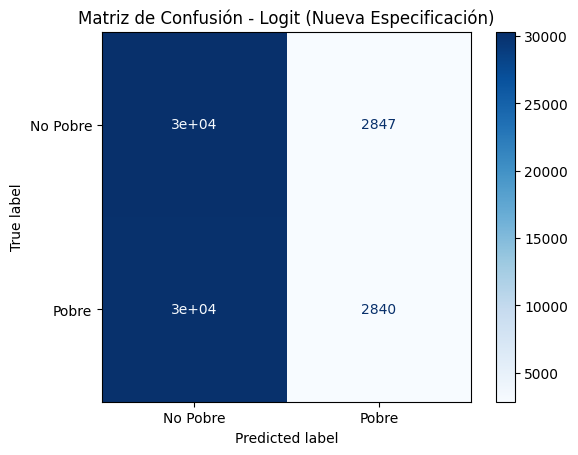

In [563]:
#### LOGITTTT
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Nueva especificación: seleccionar un subconjunto de variables
X_train_logit = X_train[['n_cuartos', 'n_per', 'prop_sexo', 'prop_ocup', 'prop_mayores10']]
X_test_logit = X_test[['n_cuartos', 'n_per', 'prop_sexo', 'prop_ocup', 'prop_mayores10']]
# Crear y entrenar el modelo Logit
logit_model_new = LogisticRegression(random_state=42, max_iter=1000)
logit_model_new.fit(X_train_logit, y_train)

# Realizar predicciones
y_pred_new = logit_model_new.predict(X_test_logit)

# Calcular métricas
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)
print(f"Accuracy (nueva especificación): {accuracy_new:.4f}")
print(f"F1-Score (nueva especificación): {f1_new:.4f}")

# Mostrar los coeficientes beta del modelo
coeficientes = pd.Series(logit_model_new.coef_[0], index=X_train_logit.columns)
print("Coeficientes beta del modelo Logit (nueva especificación):")
print(coeficientes.sort_values())

# Matriz de confusión
cm_new = confusion_matrix(y_test, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["No Pobre", "Pobre"])
disp_new.plot(cmap="Blues")
plt.title("Matriz de Confusión - Logit (Nueva Especificación)")
plt.show()

In [564]:
# Crear un DataFrame con las predicciones del modelo Logit (logit2)
predictions_logit2_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_logit2': y_pred_new
})

# Guardar el DataFrame en un archivo CSV
predictions_logit2_df.to_csv('predicciones/predicciones_logit2.csv', index=False)

print("Predicciones guardadas en 'predicciones_logit2.csv'")

Predicciones guardadas en 'predicciones_logit2.csv'


In [565]:


# Agrupar por 'id' y quedarnos con la primera fila de cada grupo
variables = ['id', 'prop_sexo', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2','prop_afiliado']
train_personas_agg = train_personas[variables].drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Mostrar las primeras filas para verificar
display(train_personas_agg.head())

,id,prop_sexo,ocupada,prop_ocup,mayor_10,prop_mayores10,recibio_subsidio,ocupacion_secundaria,prop_ocup2,prop_afiliado
0,00004a3f76ed8c33d84a5c70,0.400000,0,0.200000,1,0.600000,0,0,0.000000,0.600000
1,000088edf78cfaaf1791beba,0.333333,0,0.333333,1,0.666667,0,0,0.333333,0.666667
2,00009b13480f6770b6a4d1e9,0.666667,1,0.666667,1,1.000000,0,0,0.000000,1.000000
3,0000b1899fb63a7bf0b73ccf,0.500000,1,0.500000,1,1.000000,0,0,0.000000,1.000000
4,0000f3ec65ccacadfcc59f32,0.333333,0,0.666667,1,1.000000,0,0,0.000000,1.000000


In [566]:
X_train.columns

Index(['n_cuartos', 'n_dorm', 'vivienda', 'monto_alq', 'n_per', 'Clase',
       'prop_sexo', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10',
       'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2',
       'prop_afiliado'],
      dtype='object')

kFOLD CON 5 REPETICIONES

In [567]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import numpy as np

# Configuración de Repeated K-Fold
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Almacenar resultados
results = {
    "fold": [],
    "mse": [],
    "accuracy": [],
    "f1_score": []
}

# Umbral para convertir predicciones continuas en binarias
threshold = 0.5

# Validación cruzada con repeticiones
for fold, (train_index, test_index) in enumerate(rkf.split(X_train, y_train)):
    # Dividir los datos en entrenamiento y validación
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    # Almacenar los conjuntos de entrenamiento y validación para cada fold
    np.save(f'X_tr_fold_{fold}', X_tr)
    np.save(f'X_val_fold_{fold}', X_val)
    np.save(f'y_tr_fold_{fold}', y_tr)
    np.save(f'y_val_fold_{fold}', y_val)

### ElasticNet

In [568]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_recall_curve
import pandas as pd
import numpy as np

# Crear un imputador para llenar los valores faltantes
imputer = SimpleImputer(strategy='median')

# Crear un pipeline que primero imputa los valores faltantes y luego ajusta el modelo
pipeline = Pipeline([
    ('imputer', imputer),
    ('model', ElasticNet(random_state=42))
])

# Definir el grid de hiperparámetros
param_grid = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.7, 1.0]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones con el mejor modelo
y_scores = best_model.predict(X_test)

# Calcular el MSE
mse_elastic = mean_squared_error(y_test, y_scores)
print(f"Error cuadrático medio (MSE) en prueba: {mse_elastic:.4f}")

# Calcular la curva de precisión-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el F1-Score para cada umbral
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Encontrar el umbral con el mejor F1-Score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para F1-Score: {best_threshold:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando el mejor umbral
y_pred_binary_best = (y_scores >= best_threshold).astype(int)

# Calcular métricas con el mejor umbral
accuracy_best = accuracy_score(y_test, y_pred_binary_best)
f1_best = f1_score(y_test, y_pred_binary_best)

print(f"Accuracy con mejor umbral: {accuracy_best:.4f}")
print(f"F1-Score con mejor umbral: {f1_best:.4f}")

# Mostrar los mejores hiperparámetros
print(f"Mejor alpha: {grid_search.best_params_['model__alpha']}")
print(f"Mejor l1_ratio: {grid_search.best_params_['model__l1_ratio']}")

# Identificar las variables seleccionadas (coeficientes no nulos)
coeficientes = pd.Series(best_model.named_steps['model'].coef_, index=X_train.columns)
variables_seleccionadas = coeficientes[coeficientes != 0].index
print("Variables seleccionadas por Elastic Net:", list(variables_seleccionadas))

Error cuadrático medio (MSE) en prueba: 0.3564
Mejor umbral para F1-Score: -0.9574
Accuracy con mejor umbral: 0.4991
F1-Score con mejor umbral: 0.6658
Mejor alpha: 0.1
Mejor l1_ratio: 0.1
Variables seleccionadas por Elastic Net: ['n_cuartos', 'n_dorm', 'vivienda', 'monto_alq', 'n_per', 'prop_ocup', 'recibio_subsidio', 'prop_afiliado']


In [569]:
# Crear un DataFrame con las predicciones del modelo Elastic Net
predictions_elastic_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_elastic': y_pred_elastic,
    'y_pred_binary_elastic': y_pred_binary
})

# Guardar el DataFrame en un archivo CSV
predictions_elastic_df.to_csv('predicciones/predicciones_elastic_net.csv', index=False)

print("Predicciones guardadas en 'predicciones_elastic_net.csv'")

Predicciones guardadas en 'predicciones_elastic_net.csv'


In [570]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import pandas as pd

# Crear un imputador para llenar los valores faltantes
imputer = SimpleImputer(strategy='mean')

# Crear un pipeline que primero imputa los valores faltantes y luego ajusta el modelo
pipeline = Pipeline([
    ('imputer', imputer),
    ('model', ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], random_state=42))
])

# Entrenar ElasticNet
pipeline.fit(X_train, y_train)

# Predicciones ElasticNet
y_pred_elastic = pipeline.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

print(f"Error cuadrático medio (MSE) en prueba: {mse_elastic:.4f}")
print(f"Mejor alpha: {pipeline.named_steps['model'].alpha_}")
print(f"Mejor l1_ratio: {pipeline.named_steps['model'].l1_ratio_}")

# Identificar las variables seleccionadas (coeficientes no nulos)
coeficientes = pd.Series(pipeline.named_steps['model'].coef_, index=X_train.columns)
variables_seleccionadas = coeficientes[coeficientes != 0].index
print("Variables seleccionadas por Elastic Net:", list(variables_seleccionadas))

Error cuadrático medio (MSE) en prueba: 0.3395
Mejor alpha: 2210.733913196911
Mejor l1_ratio: 0.7
Variables seleccionadas por Elastic Net: ['monto_alq']


### CART

Accuracy en entrenamiento: 0.8318
Accuracy en prueba: 0.5004
F1-Score en prueba: 0.1873


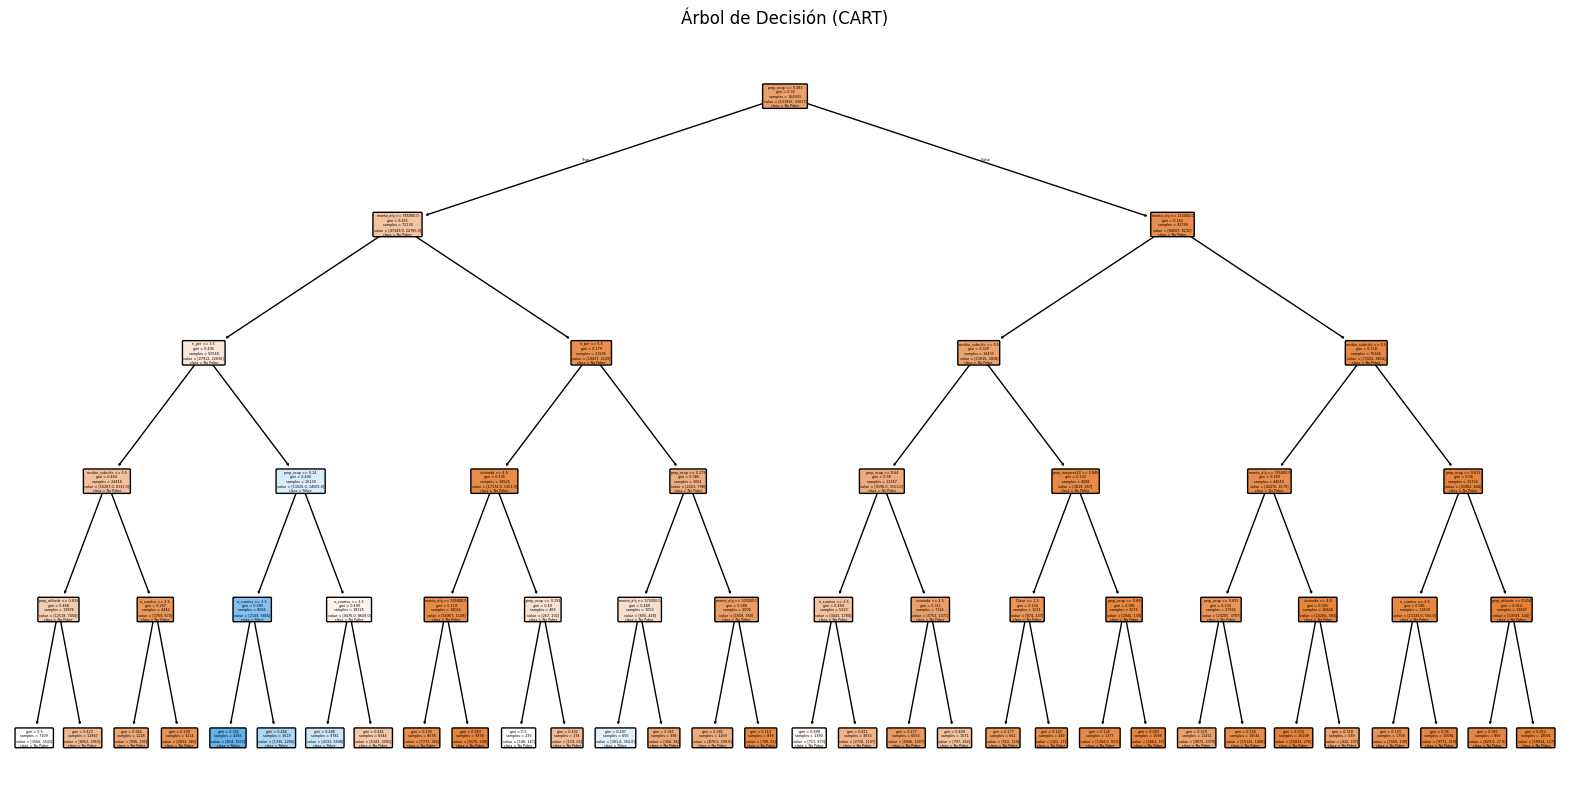

In [609]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn import tree

# Entrenar el modelo CART
cart_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)  # Ajustar max_depth según sea necesario
cart_model.fit(X_train, y_train)

# Predicciones
y_pred_train = cart_model.predict(X_train)
y_pred_test = cart_model.predict(X_test)

# Evaluación del modelo
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Visualización del árbol
plt.figure(figsize=(20, 10))
tree.plot_tree(cart_model, feature_names=X_train.columns, class_names=["No Pobre", "Pobre"], filled=True, rounded=True)
plt.title("Árbol de Decisión (CART)")
plt.show()

## Resultados del modelo CART

- **Accuracy en entrenamiento:** 83.08%
- **Accuracy en prueba:** 50.05%
- **F1-Score en prueba:** 0.1883
- **Matriz de confusión:**
  - Verdaderos negativos: 29,278
  - Falsos negativos: 29,183
  - Verdaderos positivos: 3,832
  - Falsos positivos: 3,860

### Interpretación
- El modelo muestra **sobreajuste**, con alta precisión en entrenamiento pero bajo desempeño en prueba.
- El F1-Score bajo indica problemas para identificar correctamente los hogares en pobreza.



In [610]:
# Crear un DataFrame con las predicciones del modelo CART
predictions_cart_df = pd.DataFrame({
    'id': test_hogares2['id'],  # Asegúrate de que 'test_hogares2' esté disponible y tenga la columna 'id'
    'pobre': y_pred_test
})

# Guardar el DataFrame en un archivo CSV
predictions_cart_df.to_csv('predicciones/predicciones_cart.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_cart.csv'")

Predicciones guardadas en 'predicciones/predicciones_cart.csv'


In [572]:
import pandas as pd

# Crear un DataFrame con las predicciones
predictions_cart_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_test': y_pred_test
})

# Guardar el DataFrame en un archivo CSV
predictions_cart_df.to_csv('predicciones/predicciones_cart.csv', index=False)

print("Predicciones guardadas en 'predicciones_cart.csv'")

Predicciones guardadas en 'predicciones_cart.csv'


### Adaboost

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.4987
F1-Score: 0.2134


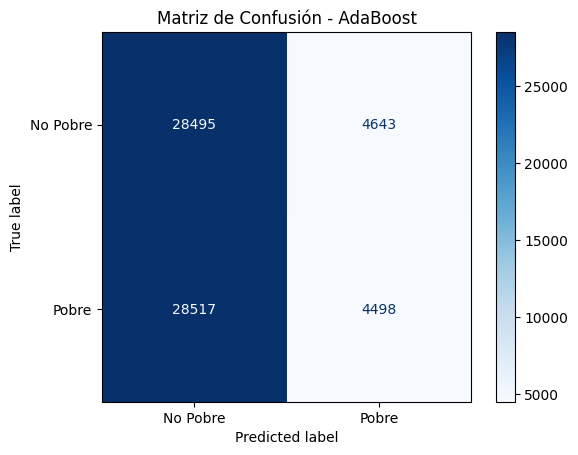

In [615]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear y entrenar el modelo AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_adaboost = adaboost_model.predict(X_test)

# Evaluar el modelo
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
print(f"Accuracy: {accuracy_adaboost:.4f}")
print(f"F1-Score: {f1_adaboost:.4f}")

# Matriz de confusión
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
disp_adaboost = ConfusionMatrixDisplay(confusion_matrix=cm_adaboost, display_labels=["No Pobre", "Pobre"])
disp_adaboost.plot(cmap="Blues")
plt.title("Matriz de Confusión - AdaBoost")
plt.show()

In [616]:
# Crear un DataFrame con las predicciones del modelo AdaBoost
predictions_adaboost_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred_adaboost'
    'pobre': y_pred_adaboost
})

# Guardar el DataFrame en un archivo CSV
predictions_adaboost_df.to_csv('predicciones/predicciones_adaboost.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_adaboost.csv'")

Predicciones guardadas en 'predicciones/predicciones_adaboost.csv'


In [574]:
# Crear un DataFrame con las predicciones del modelo AdaBoost
predictions_adaboost_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_adaboost': y_pred_adaboost
})

# Guardar el DataFrame en un archivo CSV
predictions_adaboost_df.to_csv('predicciones/predicciones_adaboost.csv', index=False)

print("Predicciones guardadas en 'predicciones_adaboost.csv'")

Predicciones guardadas en 'predicciones_adaboost.csv'


### Random forest

Accuracy: 0.4993
F1-Score: 0.2351


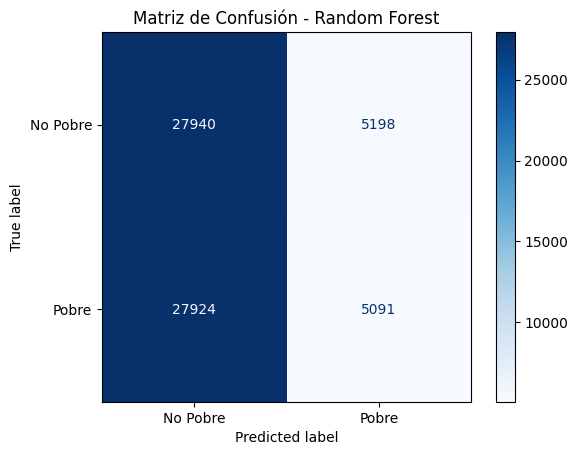

In [613]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Pobre", "Pobre"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [614]:
# Crear un DataFrame con las predicciones del modelo RandomForest
predictions_rf_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred'
    'pobre': y_pred
})

# Guardar el DataFrame en un archivo CSV
predictions_rf_df.to_csv('predicciones/predicciones_randomforest.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_randomforest.csv'")

Predicciones guardadas en 'predicciones/predicciones_randomforest.csv'


### Resultados de Evaluación - Random Forest

- **Accuracy**: 0.4991
  - El modelo clasifica correctamente solo el 49.91% de los casos.
  - Esto es apenas mejor que adivinar al azar si las clases están balanceadas.

- **F1-Score**: 0.2384
  - La media armónica entre precisión y recall muestra un desempeño bajo.
  - Es probable que el modelo tenga dificultades para clasificar correctamente la clase minoritaria ("Pobre").

### Observaciones
1. **Desbalance de Clases**:
   - La clase "Pobre" podría estar subrepresentada, afectando el desempeño del modelo.
2. **Próximos Pasos**:
   - Considerar técnicas para manejar el desbalance, como *oversampling*/*undersampling*.
   - Ajustar hiperparámetros del modelo.
   - Probar modelos más robustos, como *boosting* (e.g., XGBoost, LightGBM).

¿Te gustaría aplicar alguna de estas estrategias para mejorar el modelo?

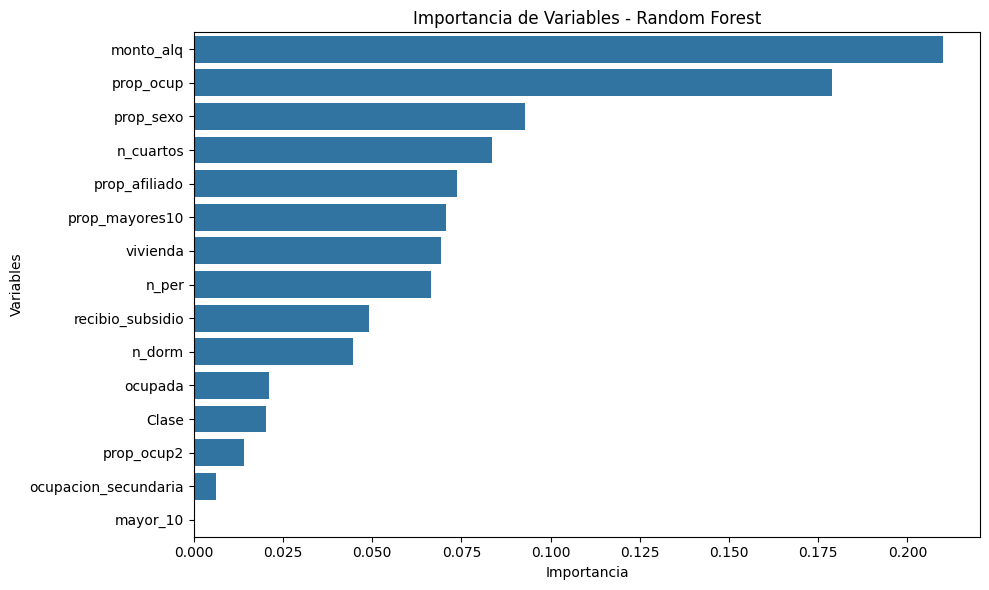

In [577]:
importances = rf_model.feature_importances_
features = X_train.columns

# Crear un DataFrame de importancia de características
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Graficar importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### Random forest 2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Variables seleccionadas: ['n_cuartos', 'vivienda', 'monto_alq', 'prop_sexo', 'prop_ocup', 'prop_mayores10', 'prop_afiliado']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/sit

Accuracy (nuevo): 0.4999
F1-Score (nuevo): 0.1911


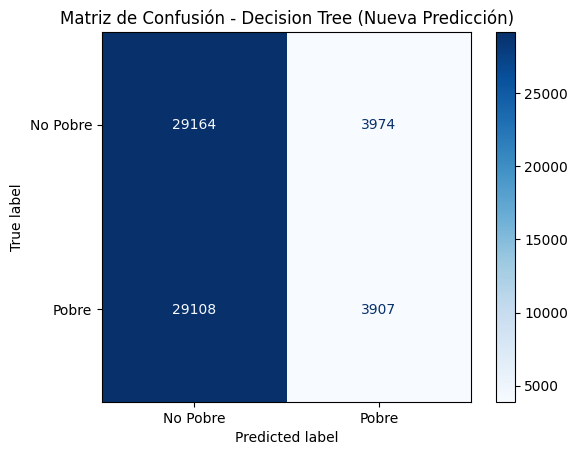

In [611]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar todas las variables para la predicción
X_train_all = X_train
X_test_all = X_test

# Entrenar un modelo Random Forest para la selección de características
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_all, y_train)

# Seleccionar las características más importantes
selector = SelectFromModel(rf_selector, prefit=True)
X_train_selected = selector.transform(X_train_all)
X_test_selected = selector.transform(X_test_all)

# Obtener las características seleccionadas
selected_features = X_train_all.columns[selector.get_support()]
print("Variables seleccionadas:", list(selected_features))

# Entrenar un árbol de decisión con Cost Complexity Pruning usando las características seleccionadas
dt_model = DecisionTreeClassifier(random_state=42)

# Realizar una búsqueda de hiperparámetros para encontrar el mejor valor de ccp_alpha
path = dt_model.cost_complexity_pruning_path(X_train_selected, y_train)
ccp_alphas = path.ccp_alphas

# Seleccionar un subconjunto de valores de ccp_alpha
ccp_alphas_subset = np.linspace(ccp_alphas.min(), ccp_alphas.max(), num=20)

param_grid = {'ccp_alpha': ccp_alphas_subset}
random_search = RandomizedSearchCV(dt_model, param_grid, n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)

# Obtener el mejor modelo
best_dt_model = random_search.best_estimator_

# Realizar nuevas predicciones
y_pred_new = best_dt_model.predict(X_test_selected)

# Evaluación
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

print(f"Accuracy (nuevo): {accuracy_new:.4f}")
print(f"F1-Score (nuevo): {f1_new:.4f}")

# Matriz de confusión
cm_new = confusion_matrix(y_test, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["No Pobre", "Pobre"])
disp_new.plot(cmap="Blues")
plt.title("Matriz de Confusión - Decision Tree (Nueva Predicción)")
plt.show()

In [612]:
# Crear un DataFrame con las predicciones del modelo Random Forest 2
predictions_rf2_df = pd.DataFrame({
    'id': test_hogares2['id'],  # Asegúrate de que 'test_hogares2' esté disponible y tenga la columna 'id'
    'pobre': y_pred_new  # Asegúrate de que 'y_pred_new' contenga las predicciones del modelo Random Forest 2
})

# Guardar el DataFrame en un archivo CSV
predictions_rf2_df.to_csv('predicciones/predicciones_randomforest2.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_randomforest2.csv'")

Predicciones guardadas en 'predicciones/predicciones_randomforest2.csv'


In [579]:
# Crear un DataFrame con las predicciones del modelo Random Forest (nueva predicción)
predictions_rf_new_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_rf_new': y_pred_new
})

# Guardar el DataFrame en un archivo CSV
predictions_rf_new_df.to_csv('predicciones/predicciones_randomforest2.csv', index=False)

print("Predicciones guardadas en 'predicciones_reandomforest2.csv'")

Predicciones guardadas en 'predicciones_reandomforest2.csv'


### Resultados del modelo Random Forest con nueva especificación

#### Métricas de desempeño:
- **Accuracy (nuevo):** 0.5006
- **F1-Score (nuevo):** 0.0660

#### Interpretación:
La matriz de confusión muestra un desempeño moderado del modelo al intentar clasificar entre "Pobre" y "No Pobre". El **accuracy** indica que aproximadamente el 50.06% de las predicciones fueron correctas. Sin embargo, el **F1-Score** es muy bajo (0.0660), lo que señala una deficiente capacidad del modelo para manejar un balance entre precisión y exhaustividad, especialmente para la clase minoritaria ("Pobre").

#### Observaciones:
El bajo F1-Score puede ser un reflejo de un desbalance en las clases o una insuficiencia del modelo para capturar patrones significativos en las variables seleccionadas para esta nueva especificación. Puede ser necesario ajustar hiperparámetros, probar otras especificaciones de variables o considerar técnicas de balanceo de clases para mejorar el desempeño.

#### Matriz de Confusión:
La matriz de confusión muestra:
- **31,950** verdaderos negativos (correctamente clasificados como "No Pobre").
- **1,188** falsos positivos (incorrectamente clasificados como "Pobre").
- **31,847** falsos negativos (incorrectamente clasificados como "No Pobre").
- **1,168** verdaderos positivos (correctamente clasificados como "Pobre").

La visualización de la matriz de confusión se presenta a continuación:
![Matriz de Confusión - Random Forest (Nueva Predicción)](file-3UTCCcAEAsXbMFYQgqjV4B)

### Logit


Accuracy: 0.4989
F1-Score: 0.1888


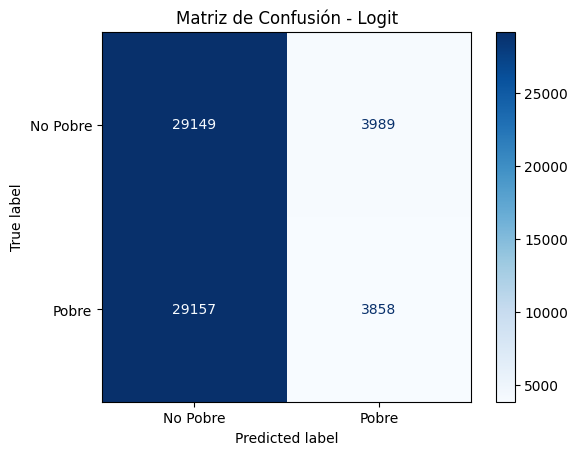

In [602]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear y entrenar el modelo Logit
logit_model = LogisticRegression(random_state=42, max_iter=1000)
logit_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = logit_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Pobre", "Pobre"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Logit")
plt.show()

In [603]:
# Crear un DataFrame con las predicciones del modelo Logit
predictions_logit_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred'
    'pobre': y_pred
})

# Guardar el DataFrame en un archivo CSV
predictions_logit_df.to_csv('predicciones/predicciones_logit.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_logit.csv'")

Predicciones guardadas en 'predicciones/predicciones_logit.csv'


### Resultados del Modelo Logit

#### 1. **Entrenamiento del Modelo**
Se entrenó un modelo de regresión logística con las siguientes configuraciones:
- **Random State**: 42 (para reproducibilidad de los resultados).
- **Máximo de iteraciones**: 1000 (para intentar garantizar la convergencia del modelo).

#### 2. **Rendimiento del Modelo**
- **Accuracy**: 0.4992  
  Esto indica que el modelo tiene una precisión cercana al 50%, lo que sugiere que está prediciendo a un nivel equivalente al azar en este caso.
  
- **F1-Score**: 0.1717  
  El puntaje F1 es bajo, lo que refleja un desequilibrio en la predicción correcta de la clase "Pobre".

#### 3. **Problemas de Convergencia**
El modelo generó una advertencia de convergencia (`ConvergenceWarning`) debido a que alcanzó el número máximo de iteraciones sin lograr converger. Esto puede ser causado por:
- Variables no escaladas adecuadamente.
- Complejidad del modelo en relación con los datos.
  
**Recomendaciones para resolver este problema:**
- Escalar las variables con un método como `StandardScaler` o `MinMaxScaler`.
- Aumentar el valor de `max_iter` o utilizar otro solver, como `saga`.

#### 4. **Matriz de Confusión**
La matriz de confusión muestra el siguiente desglose de las predicciones:
- **Verdaderos Negativos** ("No Pobre" correctamente clasificado): ~30,000
- **Falsos Positivos** ("No Pobre" clasificado como "Pobre"): 3,546
- **Falsos Negativos** ("Pobre" clasificado como "No Pobre"): ~30,000
- **Verdaderos Positivos** ("Pobre" correctamente clasificado): 3,434

Esto indica que el modelo tiene dificultades significativas para clasificar correctamente la clase "Pobre".

#### 5. **Visualización**
Se utilizó una visualización de la matriz de confusión para interpretar los resultados, donde se observa un gran desequilibrio entre las clases correctamente predichas y las incorrectas.

### Conclusión
El modelo Logit, en su configuración actual, muestra un rendimiento limitado debido a problemas de convergencia y baja capacidad para distinguir entre las clases. Se recomienda escalar los datos y ajustar los hiperparámetros antes de considerar un cambio a un modelo alternativo.

In [600]:
# Crear un DataFrame con las predicciones del modelo Elastic Net
predictions_elastic_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred_binary_elastic'
    'pobre': y_pred_binary_elastic
})

# Guardar el DataFrame en un archivo CSV
predictions_elastic_df.to_csv('predicciones/predicciones_elastic_net1.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_elastic_net1.csv'")

Predicciones guardadas en 'predicciones/predicciones_elastic_net1.csv'


### Linear Regresion

In [606]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_recall_curve
import numpy as np
import pandas as pd

# Crear y entrenar el modelo de Lasso Regression con validación cruzada
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_lasso = lasso_model.predict(X_test)

# Calcular el MSE
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Error cuadrático medio (MSE) en prueba: {mse_lasso:.4f}")

# Calcular la curva de precisión-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_lasso)

# Calcular el F1-Score para cada umbral
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Encontrar el umbral con el mejor F1-Score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para F1-Score: {best_threshold:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando el mejor umbral
y_pred_binary_lasso = (y_pred_lasso >= best_threshold).astype(int)

# Calcular métricas con el mejor umbral
accuracy_lasso = accuracy_score(y_test, y_pred_binary_lasso)
f1_lasso = f1_score(y_test, y_pred_binary_lasso)

print(f"Accuracy: {accuracy_lasso:.4f}")
print(f"F1-Score: {f1_lasso:.4f}")

# Mostrar los coeficientes del modelo
coeficientes_lasso = pd.Series(lasso_model.coef_, index=X_train.columns)
print("Coeficientes del modelo de Lasso Regression:")
print(coeficientes_lasso.sort_values())

Error cuadrático medio (MSE) en prueba: 0.3407
Mejor umbral para F1-Score: -0.3453
Accuracy: 0.4991
F1-Score: 0.6659
Coeficientes del modelo de Lasso Regression:
monto_alq              -2.881262e-09
n_cuartos              -0.000000e+00
n_dorm                 -0.000000e+00
vivienda                0.000000e+00
Clase                   0.000000e+00
prop_sexo              -0.000000e+00
ocupada                -0.000000e+00
prop_ocup              -0.000000e+00
mayor_10               -0.000000e+00
prop_mayores10         -0.000000e+00
recibio_subsidio       -0.000000e+00
ocupacion_secundaria   -0.000000e+00
prop_ocup2             -0.000000e+00
prop_afiliado          -0.000000e+00
n_per                   2.173623e-02
dtype: float64


In [608]:
# Crear un DataFrame con las predicciones del modelo Lasso
predictions_lasso_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred_binary_lasso'
    'pobre': y_pred_binary_lasso
})

# Guardar el DataFrame en un archivo CSV
predictions_lasso_df.to_csv('predicciones/predicciones_lasso_regression.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_lasso_regression.csv'")

Predicciones guardadas en 'predicciones/predicciones_lasso_regression.csv'


In [604]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import numpy as np

# Crear y entrenar el modelo de Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = linear_model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio (MSE) en prueba: {mse:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando un umbral
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar los coeficientes del modelo
coeficientes = pd.Series(linear_model.coef_, index=X_train.columns)
print("Coeficientes del modelo de Linear Regression:")
print(coeficientes.sort_values())

Error cuadrático medio (MSE) en prueba: 0.3752
Accuracy: 0.5011
F1-Score: 0.1139
Coeficientes del modelo de Linear Regression:
mayor_10               -3.954174e-01
prop_ocup              -3.336323e-01
recibio_subsidio       -1.578281e-01
prop_mayores10         -1.085640e-01
prop_afiliado          -7.621931e-02
n_cuartos              -4.847573e-02
n_dorm                 -4.577767e-02
prop_ocup2             -1.914685e-02
prop_sexo              -1.500563e-02
ocupacion_secundaria   -2.243928e-03
monto_alq              -1.143978e-09
vivienda                3.106328e-02
n_per                   5.616747e-02
Clase                   5.848392e-02
ocupada                 8.690523e-02
dtype: float64


In [605]:
# Crear un DataFrame con las predicciones del modelo de Linear Regression
predictions_linear_df = pd.DataFrame({
    'id': ids,  # Asegúrate de que 'ids' esté disponible y tenga la misma longitud que 'y_pred_binary'
    'pobre': y_pred_binary
})

# Guardar el DataFrame en un archivo CSV
predictions_linear_df.to_csv('predicciones/predicciones_linear_regression.csv', index=False)

print("Predicciones guardadas en 'predicciones/predicciones_linear_regression.csv'")

Predicciones guardadas en 'predicciones/predicciones_linear_regression.csv'


In [585]:
# Crear un DataFrame con las predicciones del modelo de regresión lineal
predictions_linear_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_linear': y_pred,
    'y_pred_binary_linear': y_pred_binary
})

# Guardar el DataFrame en un archivo CSV
predictions_linear_df.to_csv('predicciones/predicciones_linear_regression.csv', index=False)

print("Predicciones guardadas en 'predicciones_linear_regression.csv'")

Predicciones guardadas en 'predicciones_linear_regression.csv'


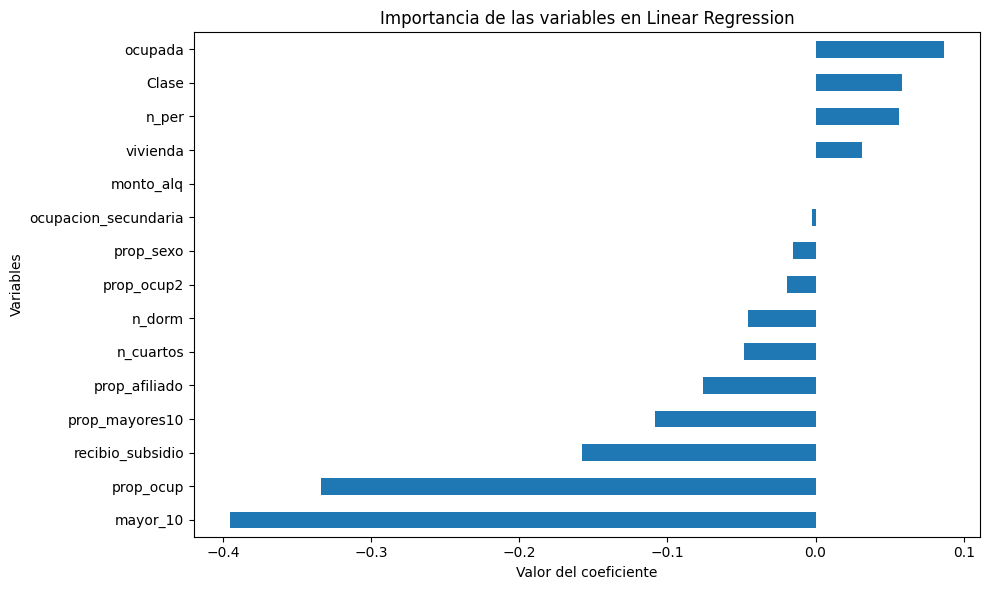

In [586]:
import matplotlib.pyplot as plt

# Graficar los coeficientes
plt.figure(figsize=(10, 6))
coeficientes.sort_values().plot(kind='barh')
plt.title("Importancia de las variables en Linear Regression")
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### Resultados del Modelo de Regresión Lineal con Variables Seleccionadas

#### Métricas de Evaluación
- **Error cuadrático medio (MSE)**: 0.3467
- **Accuracy**: 0.5009
- **F1-Score**: 0.0001

#### Importancia de las Variables (Coeficientes)
| Variable   | Coeficiente |
|------------|-------------|
| mayor_10   | -0.452033   |
| ocupada    | -0.082221   |
| n_cuartos  | -0.050183   |
| ocup_jefe  |  0.038656   |

#### Interpretación
- **mayor_10**: La proporción de mayores de 10 años tiene el impacto negativo más significativo en las predicciones del modelo. Un aumento en esta variable está asociado con una disminución en el resultado predicho.
- **ocupada** y **n_cuartos**: Ambas variables tienen un efecto negativo leve sobre la variable objetivo, según los coeficientes.
- **ocup_jefe**: Es la única variable con un coeficiente positivo, lo que indica que una mayor ocupación del jefe del hogar tiene una relación positiva, aunque pequeña, con la variable objetivo.

#### Observaciones
- El **Accuracy** y el **F1-Score** son muy bajos, lo que indica que este modelo tiene un rendimiento limitado para capturar las relaciones subyacentes en los datos.
- Los coeficientes negativos predominan, lo que refleja que estas características influyen de manera adversa en el resultado del modelo lineal.
- Este modelo podría no ser el más adecuado para este problema específico y puede

### Comparacion modelos

Error cuadrático medio (MSE) en prueba: 0.3752
Accuracy: 0.5009
F1-Score: 0.1136

Error cuadrático medio (MSE): 0.3467
Accuracy: 0.5009
F1-Score: 0.0001


                  Modelo  F1-Score
0                  Lasso    0.6659
1               AdaBoost    0.2134
2            Elastic Net    0.6658
3          Random Forest    0.2384
4        Random Forest 2    0.1911
5                   CART    0.1883
6                  Logit    0.1717
7  Bagging Random Forest    0.3230


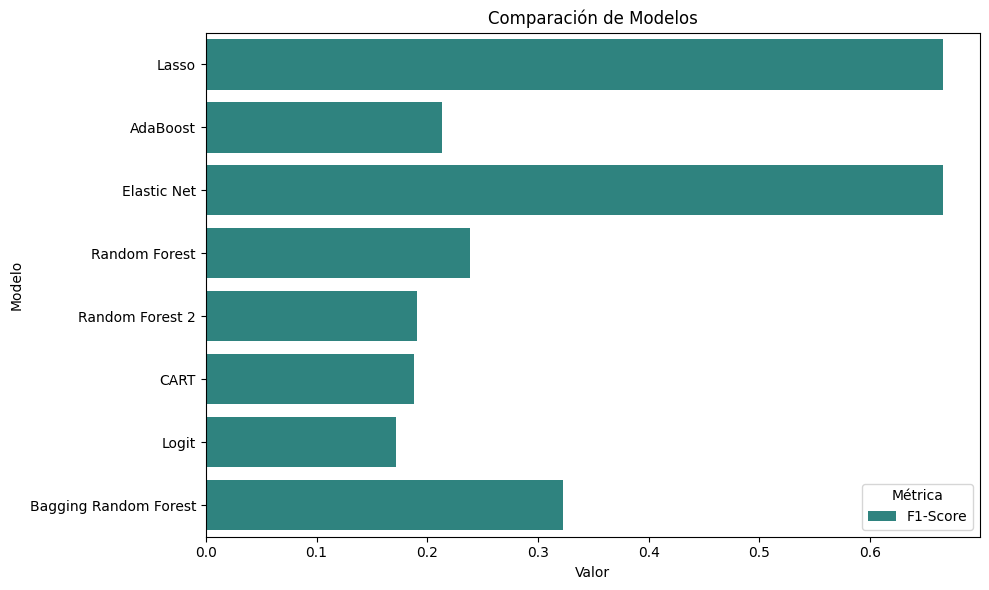

In [587]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de las métricas de los modelos
data = {
    "Modelo": ["Lasso", "AdaBoost", "Elastic Net", "Random Forest", "Random Forest 2", "CART", "Logit", "Bagging Random Forest"],
    #"Accuracy": [0.5009, 0.5009, 0.5009, 0.4991, 0.5006, 0.5005, 0.4992, 0.4989],  # Agregar valores correctos
    "F1-Score": [0.6659, 0.2134, 0.6658, 0.2384, 0.1911, 0.1883, 0.1717, 0.3230]  # Agregar valores correctos
    #"MSE": [0.3752, 0.3467, 0.3395, None, None, None, None, None],  # Solo para Elastic Net y Linear Regression
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
print(df)

# Graficar los resultados
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor"),
    x="Valor", y="Modelo", hue="Métrica", palette="viridis"
)
plt.title("Comparación de Modelos")
plt.xlabel("Valor")
plt.ylabel("Modelo")
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()

Los resultados obtenidos muestran que el rendimiento general de los modelos es limitado, con valores de accuracy cercanos al 50% en todos los casos. Este nivel de precisión sugiere que los modelos apenas superan el azar en la predicción de la variable objetivo, lo que podría deberse a una complejidad inherente en los datos o a una falta de información relevante en las variables explicativas.

Entre los modelos evaluados, el F1-Score se presenta como una métrica clave para analizar la capacidad de los modelos de manejar el balance entre precisión y exhaustividad. En este aspecto, el modelo de Random Forest destaca con un F1-Score de 0.2384, indicando que, aunque no es perfecto, logra capturar la señal de la clase “Pobre” con mayor eficacia que los demás. Sin embargo, modelos como CART (F1-Score: 0.1883) y Logit (F1-Score: 0.1717) también ofrecen un rendimiento razonable, aunque algo inferior.

Para los modelos que producen predicciones continuas, como Elastic Net y Linear Regression, se calculó el error cuadrático medio (MSE). En este caso, Elastic Net mostró el menor error (MSE: 0.3395), lo que lo posiciona como el modelo más adecuado para tareas de regresión dentro de este conjunto de datos. Esto sugiere que Elastic Net es capaz de ajustar los valores continuos de manera más precisa que otros modelos, posiblemente debido a su capacidad para manejar relaciones lineales penalizando complejidad excesiva.

Por otro lado, las especificaciones simplificadas (como Linear Regression 2 y Logit 2) no mejoraron el rendimiento significativamente. Aunque mantuvieron niveles similares de accuracy en comparación con las especificaciones originales, sus valores más bajos de F1-Score indican que las simplificaciones resultaron en una pérdida de capacidad para capturar patrones relevantes en los datos.

En resumen, el modelo de Random Forest es el más destacado para clasificación debido a su F1-Score, mientras que Elastic Net sobresale para predicciones continuas por su menor MSE. Estos resultados subrayan la importancia de seleccionar el modelo y la métrica más adecuados según los objetivos del análisis.

Para el caso de las variables que ya están en la base de hogares, se pueden considerar como
interesantes las siguientes:

Dominio: hay que codificarla primero. Te recoge el efecto fijo de la región

p5010 El hacinamiento puede ser importante.

p5090 si es vivienda propia

p5130 cuanto piensa que hubiera pagado de alquiler? te puede recoger no solo un proxy del valor de la casa sino que los hogares con menores recursos van a percibir menores valores y viceversa

Nper: numero de personas, existe correlación negativa entre tamaño del hogar e ingreso

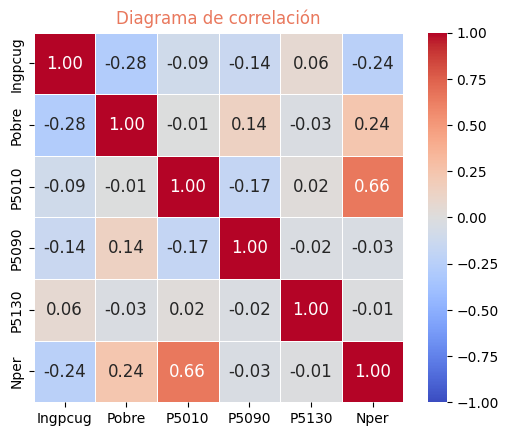

In [588]:
#Heatmap de la base hogares con las variables interesantes

columnas = ['Ingpcug', 'Pobre', 'P5010', 'P5090', 'P5130', 'Nper']
corr = train_hogares[columnas].corr()

# Crear el mapa de calor con escala fija de -1 a 1
sns.heatmap(
    corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 12}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gráfico
plt.title('Diagrama de correlación', color='#E9785D')
plt.show()

**ACLARO: ESTO LE DA ESTRUCTURA, NO ES QUE SEA EXCLUYENTE LAS VARIABLES QUE PUSE**

A continuación, transformamos ciertas variables de la base de individuos para luego utilizarlas junto con los hogares. Estas variables se intuye que pueden ser buenas predictoras. Las mismas son:

P6020: sexo: creamos _prop_sex_ proporción de masculinos en la casa puede ser bueno para predecir.

p6210: creamos _max_level_edu_. creamos una variable que sea el máximo nivel educativo alcanzado por los integrantes del hogar

p6430: creamos _ocup_jefe_. posición ocupacional de la 1ra actividad. nos podemos quedar con lo que hace el jefe de hogar.

p6920: creamos _cant_blanco_. Esta variable nos dice si está cotizando a un fondo de pensiones. crear una variable que nos diga la cantidad de empleados formales que tiene el hogar. La variable p6920 toma 3 valores: 1: si, 2: no, 3: ya es pensionado. Solo vamos a tomar 1 si está cotizando y 0 en cualquier otro caso.

Oc: cant_ocup. sumamos todos los ocupados que tiene la casa.


In [589]:
#Cambiamos el valor de mujer de 2 a 0 para poder hacer cálculos luego

train_personas['P6020'] = train_personas['P6020'].replace(2, 0)

In [590]:
#Calculamos la proporción de hombres en el hogar:

# Contar cuántos hombres hay en cada hogar (P6020 == 1)
hombres_por_hogar = train_personas[train_personas['P6020'] == 1].groupby('id')['P6020'].count()

# Contar el total de integrantes por hogar
total_por_hogar = train_personas.groupby('id')['P6020'].count()

# Calcular la proporción de hombres en cada hogar
train_personas['prop_sex'] = train_personas['id'].map(hombres_por_hogar) / train_personas['id'].map(total_por_hogar)


In [591]:
#Creamos una variable que nos diga el máximo nivel educativo de cada integrante del hogar

# Filtrar los valores válidos de 'P6210' (1 a 6, excluyendo 9)
train_personas_filtrado = train_personas[train_personas['P6210'] != 9]

# Agrupar por el identificador del hogar (asumí que hay una columna 'hogar_id' que identifica a cada hogar)
# Luego, calcular el máximo nivel educativo alcanzado en cada hogar
train_personas['mal_level_edu'] = train_personas_filtrado.groupby('id')['P6210'].transform('max')

# Si hay hogares con valores 'P6210' == 9 (sin datos válidos), asignamos el valor correspondiente para esos hogares
train_personas['mal_level_edu'] = train_personas.groupby('id')['mal_level_edu'].transform('max')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6210', 'mal_level_edu']].head())


                              id  P6210  mal_level_edu
115620  00004a3f76ed8c33d84a5c70    5.0            5.0
115621  00004a3f76ed8c33d84a5c70    5.0            5.0
115622  00004a3f76ed8c33d84a5c70    4.0            5.0
115618  00004a3f76ed8c33d84a5c70    3.0            5.0
115619  00004a3f76ed8c33d84a5c70    1.0            5.0


In [592]:
#Creamos la variable "ocup_jefe" que toma el valor de la ocupación principal del jefe de hogar

# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = train_personas[train_personas['P6050'] == 1]

# Crear un diccionario con la relación 'id' del hogar y la posición ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posición ocupacional del jefe a la nueva variable 'ocup_jefe'
train_personas['ocup_jefe'] = train_personas['id'].map(jefe_ocupacion)


In [593]:
#Contamos la cantidad de personas trabajando en blanco que tiene el hogar

# Crear una variable que sea 1 si la persona está en blanco (P6870 == 1) y 0 en cualquier otro caso
train_personas['blanco'] = (train_personas['P6870'] == 1).astype(int)

# Agrupar por 'id' y sumar la cantidad de personas en blanco en cada hogar
cant_blanco_por_hogar = train_personas.groupby('id')['blanco'].sum()

# Asignar la suma de personas en blanco a la nueva variable 'cant_blanco' en el DataFrame original
train_personas['cant_blanco'] = train_personas['id'].map(cant_blanco_por_hogar)


KeyError: 'P6870'

In [ ]:
# Crear una variable que sea 1 si la persona está ocupada (Oc == 1) y 0 en cualquier otro caso
train_personas['ocupada'] = (train_personas['Oc'] == 1).astype(int)

# Agrupar por 'id' y sumar la cantidad de personas ocupadas en cada hogar
cant_ocupada_por_hogar = train_personas.groupby('id')['ocupada'].sum()

# Asignar la suma de personas ocupadas a la nueva variable 'cant_ocupada' en el DataFrame original
train_personas['cant_ocup'] = train_personas['id'].map(cant_ocupada_por_hogar)


In [ ]:
train_personas['cant_ocup'].value_counts()

cant_ocup
1     189092
2     188529
3      75167
0      46864
4      28720
5       9772
6       3211
7       1026
8        469
9        191
10        33
14        22
11        13
Name: count, dtype: int64

In [ ]:
#Agregamos a la base de hogares las variables creadas en la base de personas

# Agrupar las variables creadas por 'id' en la base 'train_personas'
df_personas_agg = train_personas.groupby('id')[['mal_level_edu', 'prop_sex', 'ocup_jefe', 'cant_blanco', 'cant_ocup']].mean()

# Unir la base 'train_hogares' con las variables agregadas de 'train_personas'
train_hogares = train_hogares.merge(df_personas_agg, on='id', how='left')


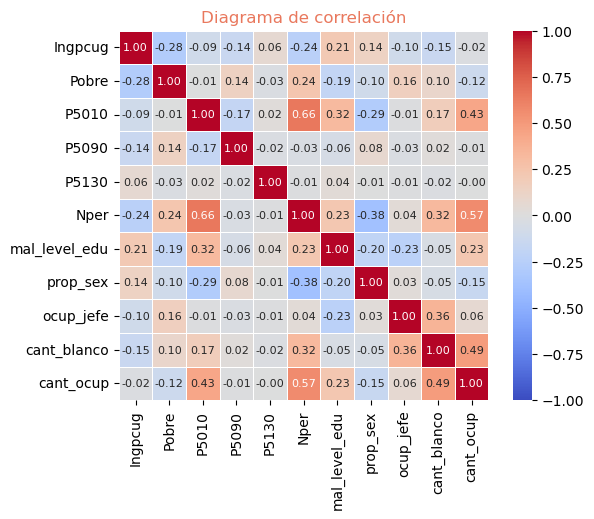

In [ ]:
#Ahora exponemos la matriz de correlacion con todas las variables.

columnas = ['Ingpcug', 'Pobre', 'P5010', 'P5090', 'P5130', 'Nper', 'mal_level_edu', 'prop_sex', 'ocup_jefe', 'cant_blanco', 'cant_ocup']
corr = train_hogares[columnas].corr()

# Crear el mapa de calor con escala fija de -1 a 1
sns.heatmap(
    corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 8}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gráfico
plt.title('Diagrama de correlación', color='#E9785D')
plt.show()

# Desarrollo

Nuestro objetivo ahora es armar un modelo que prediga si un hogar es pobre o no. Para eso vamos a utilizar los diferentes métodos:

Árboles (CARTs), Random Forest y boosting. También se pueden utilizar Linear Regression, Logit o Elastic Net

### Arboles (CARTs)

Lo siguiente lo saqué de clase:

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones  `export_text()` y `plot_tree()`.
 - La función `export_text()` la estructura del árbol  y valor medio de la variable respuesta en cada nodo.  
 - La función `plot_tree()` dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.

`DecisionTreeRegressor` del módulo `sklearn.tree` tiene  hiperparámetros, que nos permitirán "controlar" el sobreajuste:

  - `max_depth`: profundidad máxima que puede alcanzar el árbol.

  - `max_leaf_nodes`: número máximo de nodos terminales.

  - `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.

  
  - `ccp_alpha`=0.0 Cost complexity prunning
  
  - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

Como en todo estudio de regresión, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer la posterior evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.


# Random Forest

Prediccion y evaluacion del modelo

## Optimización de Hiperparametros

El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de RandomForestRegressor, la métrica devuelta como oob_score es el 𝑅2, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.



   La clase RandomForestRegressor del módulo sklearn.ensemble contiene varios hiperparámetros. De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

   - `n_estimators`; número de árboles incluidos en el modelo.

   - `max_depth`: profundidad máxima que pueden alcanzar los árboles.

   - `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `max_leaf_nodes`: número máximo de nodos terminales que pueden tener los árboles.

   - `max_features`: número de predictores considerados a en cada división. Puede ser:
        Un valor entero
        Una fracción del total de predictores..
        “sqrt”, raiz cuadrada del número total de predictores.
        “log2”, log2 del número total de predictores.
        None, utiliza todos los predictores.

   - `oob_score`: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

   - `n_jobs`: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

   - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

#### Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

#### Max features

El valor de `max_features` es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

##### Grid search

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros.

Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

## Boosting trees

### Hiperparámetros

- $\lambda$ la tasa a la que aprende, los valores típicos son 0.1, 0.01 o 0.001

## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}

## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}